# SPZ - OMC

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from meteostat import Point, Daily
from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import warnings
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from sklearn.model_selection import GridSearchCV
from prophet import Prophet
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import genextreme as gev, norm
from scipy.stats import genpareto

Importing plotly failed. Interactive plots will not work.


## Abruf historischer Wetterdaten für Bakersfield (1980–2024)

Zunächst wird ein Zeitintervall von Januar 1980 bis März 2024 definiert. Der frühere Standardbeginn von 1940 wurde bewusst auf 1980 verschoben, um mögliche Lücken in der Datenverfügbarkeit zu vermeiden – insbesondere in ländlichen Regionen oder kleineren Wetterstationen.

Anschliessend wird ein geographischer Punkt mit den Koordinaten von **Bakersfield, Kalifornien (USA)** festgelegt. Die Klasse `Point` aus dem `meteostat`-Paket ermöglicht es, diesen Standort eindeutig zu definieren.

Mithilfe der Methode `Daily(...).fetch()` werden schliesslich tägliche Wetterdaten für den gegebenen Zeitraum und Standort abgerufen. Die resultierenden Daten enthalten typischerweise Variablen wie Tageshöchst- und -tiefsttemperatur, Niederschlag, Schneefall und weitere meteorologische Größen – sofern von der jeweiligen Wetterstation verfügbar.

In [2]:
# Zeitraum für Vergangenheitsdaten (letzte 50 Jahre, falls verfügbar)
start_date = datetime(1980, 1, 1)  # Statt 1940, um Lücken zu vermeiden
end_date = datetime(2024, 3, 1)

# Punkt für Bakersfield, USA
location = Point(35.3733, -119.0187)

# Daten von Meteostat API abrufen
data = Daily(location, start_date, end_date).fetch()

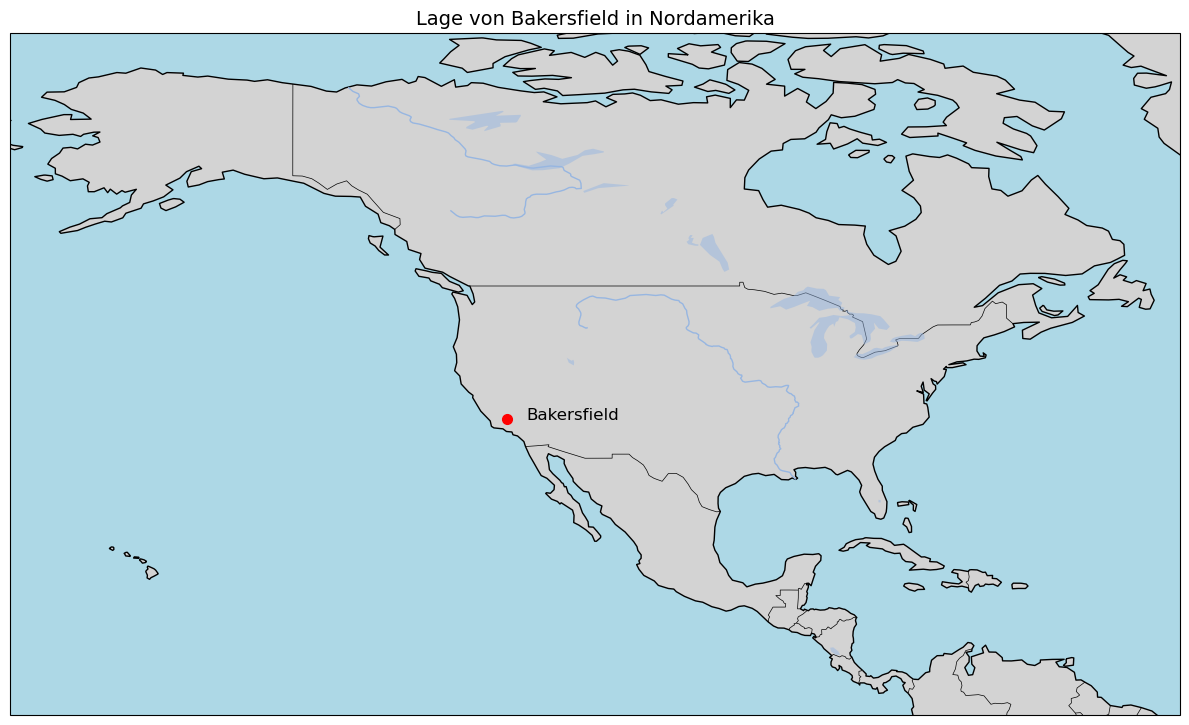

In [3]:
# Koordinaten von Bakersfield
lat, lon = 35.3733, -119.0187

# Karte von ganz Nordamerika
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-170, -50, 5, 75], crs=ccrs.PlateCarree())  # Nordamerika-Ausschnitt

# Basis-Features
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.5)
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Bakersfield markieren
ax.plot(lon, lat, marker='o', color='red', markersize=7, transform=ccrs.PlateCarree())
ax.text(lon + 2, lat, 'Bakersfield', transform=ccrs.PlateCarree(), fontsize=12)

# Titel
plt.title('Lage von Bakersfield in Nordamerika', fontsize=14)
plt.tight_layout()
plt.show()

## Explorative Datenanalyse (EDA) der Wetterzeitreihe

In diesem Abschnitt wird eine erste deskriptive Analyse der abgerufenen Wetterdaten durchgeführt, um ein besseres Verständnis der Datenstruktur und -verteilung zu erlangen:

### Statistische Kennzahlen
Die Methode `data.describe()` liefert zentrale Lage- und Streuungsmasse (Minimum, Maximum, Mittelwert, Standardabweichung, Quartile) für jede numerische Spalte im Datensatz. Dies hilft dabei, typische Wertebereiche zu erkennen und potenzielle Ausreisser frühzeitig zu identifizieren.

### Prüfung auf fehlende Werte
Mit `data.isnull().sum()` wird die Anzahl fehlender Werte pro Spalte ausgegeben. Fehlende Werte sind ein häufiger Bestandteil meteorologischer Zeitreihen und können Modellgüte und Interpretation beeinflussen.

### Histogramme
Durch die Visualisierung aller numerischen Variablen mittels `data.hist()` werden die Verteilungen (z. B. Normalverteilung, Schiefe, Mehrgipfligkeit) sichtbar. Diese Information ist besonders nützlich für Modellannahmen und spätere Transformationen.

### Korrelationsmatrix
Die Heatmap auf Basis der Korrelationsmatrix zeigt lineare Zusammenhänge zwischen den Variablen. Dies unterstützt die Auswahl geeigneter Prädiktoren für multivariate Modelle und kann helfen, Redundanzen zu erkennen. Beispiel: Eine starke Korrelation zwischen `tmax`, `tmin` und `tavg` ist meteorologisch zu erwarten.

### Boxplot der Durchschnittstemperatur (`tavg`)
Ein Boxplot wird verwendet, um Ausreisser visuell zu identifizieren und die Verteilung der mittleren Tagestemperatur zu zeigen. Der Boxplot verdeutlicht Spannweite (IQR), Median und potenziell extreme Werte.

### Bereinigung von Ausreissern mittels IQR-Methode
Zur Behandlung von Ausreissern in der Temperaturreihe wird die IQR-Methode angewandt. Dabei werden alle Werte ausserhalb des Intervalls  
$$
  IQR = Q_3 - Q_1 = 25{,}6^\circ C - 12{,}2^\circ C = 13{,}4^\circ C
$$
beschnitten (clipping). Diese robuste Methode reduziert den Einfluss extremer Ausreisser, ohne die restliche Verteilung zu verändern – eine bewährte Vorgehensweise bei Zeitreihen mit physikalisch begründbaren Grenzen.


               tavg          tmin          tmax          prcp          snow  \
count  15808.000000  16132.000000  16132.000000  16132.000000  16130.000000   
mean      18.692371     11.926141     25.665485      0.435148      0.004712   
std        7.924751      6.987263      8.914693      2.099032      0.598407   
min      -17.800000     -7.200000      1.100000      0.000000      0.000000   
25%       12.200000      6.100000     18.300000      0.000000      0.000000   
50%       18.000000     11.100000     25.600000      0.000000      0.000000   
75%       25.600000     17.800000     33.300000      0.000000      0.000000   
max       37.200000     30.000000     46.100000     38.900000     76.000000   

              wdir          wspd         wpgt          pres    tsun  
count  6303.000000  16114.000000  5765.000000  15691.000000  1137.0  
mean    236.082659      9.953736    27.918508   1015.376566     0.0  
std     130.245037      3.673261     9.454404      5.222066     0.0  
min     

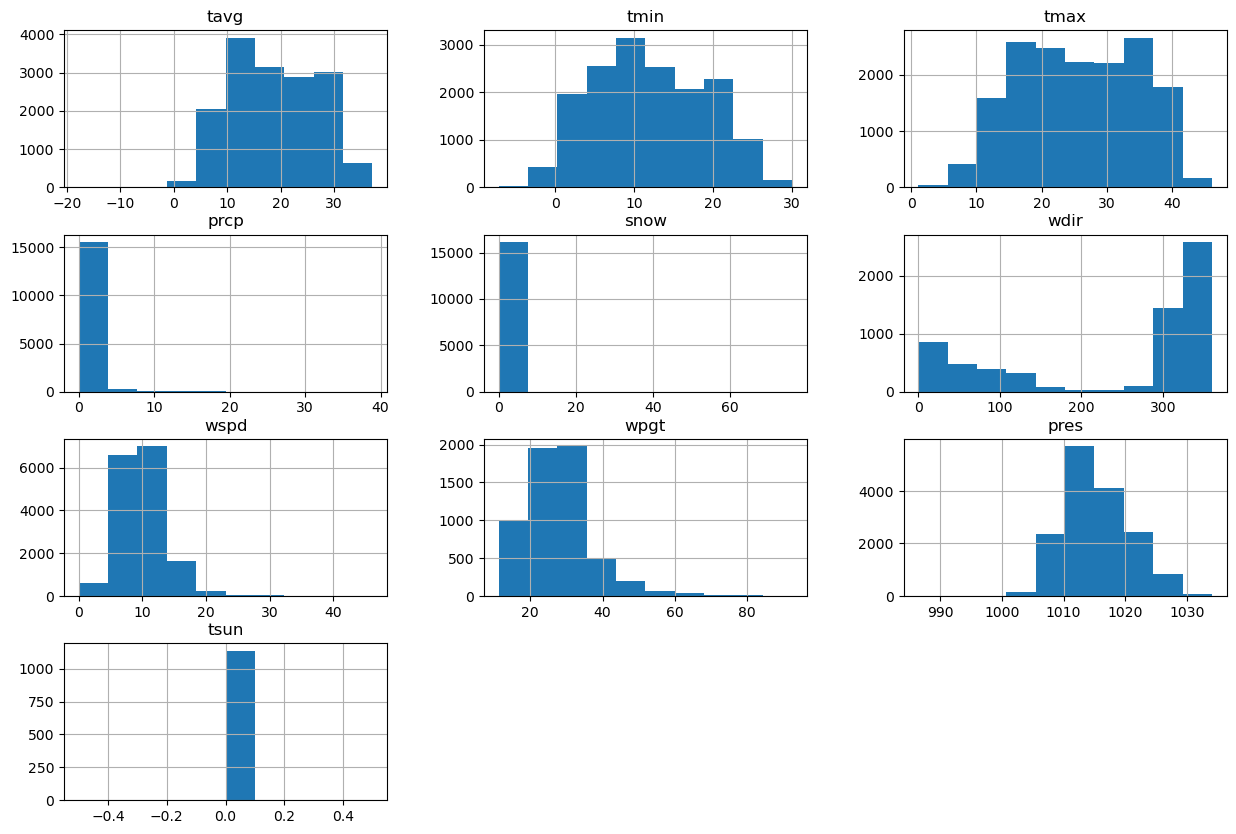

-------------------------------------------------------------


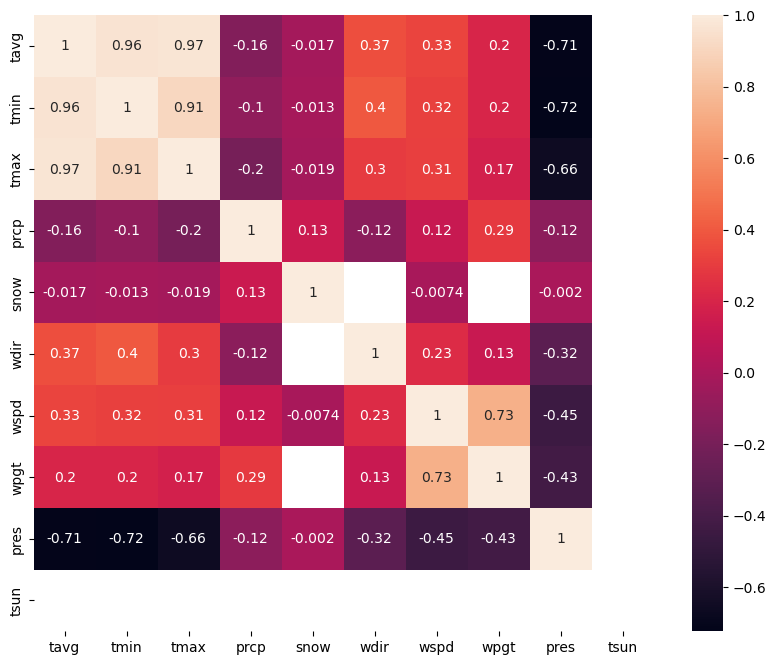

-------------------------------------------------------------


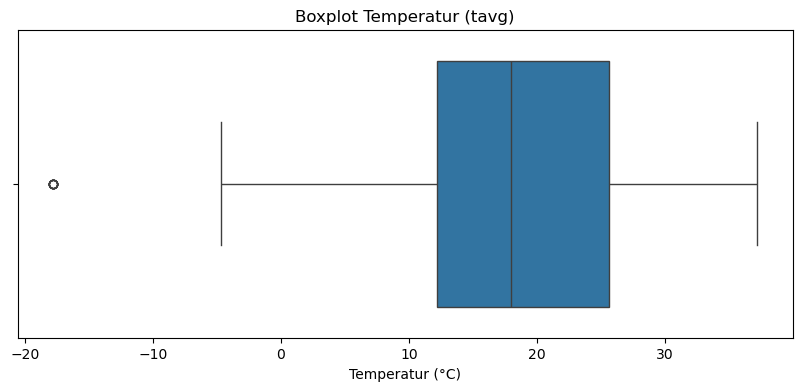

In [4]:
print(data.describe())

print('-------------------------------------------------------------')

print(data.isnull().sum())

print('-------------------------------------------------------------')

data.hist(figsize=(15, 10))
plt.show()

print('-------------------------------------------------------------')

plt.figure(figsize=(10, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

print('-------------------------------------------------------------')

plt.figure(figsize=(10, 4))
sns.boxplot(x=data['tavg'])
plt.title('Boxplot Temperatur (tavg)')
plt.xlabel('Temperatur (°C)')
plt.show()

Q1 = data['tavg'].quantile(0.25)
Q3 = data['tavg'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data['tavg'] = data['tavg'].clip(lower=lower_bound, upper=upper_bound)

## Zeitliche Entwicklung der durchschnittlichen Temperatur

Diese Visualisierung zeigt den Verlauf der durchschnittlichen Tagestemperatur (`tavg`) über den gesamten Untersuchungszeitraum von 1980 bis 2024. 

Durch die Verwendung von `plt.plot(...)` mit dem Zeitindex der DataFrame als x-Achse wird eine klassische Zeitreihe erzeugt, die saisonale Schwankungen, Langzeittrends (z. B. Klimaveränderungen), sowie Extremwerte sichtbar macht.

### Interpretation:
- **Saisonalität:** Wiederkehrende Muster im Jahresrhythmus lassen sich leicht erkennen (z. B. Sommer-/Winterzyklen).
- **Langfristige Trends:** Ein möglicher Temperaturanstieg im Laufe der Jahrzehnte wäre visuell erkennbar und könnte später modelliert werden.
- **Datenqualität:** Ungewöhnliche Sprünge oder Lücken würden auf Messfehler oder fehlende Werte hinweisen.

Die klare Visualisierung dieser langfristigen Entwicklung ist essenziell, um die Eignung der Daten für Zeitreihenmodelle wie SARIMA oder Prophet zu beurteilen.

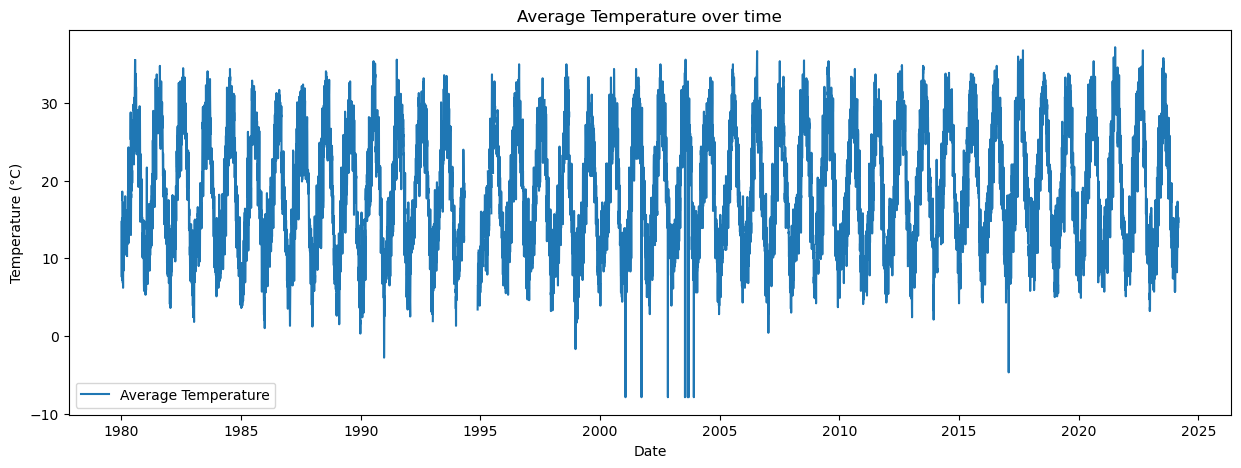

In [5]:
plt.figure(figsize=(15, 5))
plt.plot(data.index, data['tavg'], label='Average Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Average Temperature over time')
plt.legend()
plt.show()

### Umgang mit Ausreissern und fehlenden Werten: Zeitbasierte Imputation

Die Qualität von Zeitreihenmodellen hängt entscheidend von der **Zuverlässigkeit der Eingangsdaten** ab. In diesem Abschnitt werden methodisch Ausreisser identifiziert und die betroffenen Bereiche mithilfe zweier Imputationsverfahren bereinigt.

#### 1. Z-Score-basiertes Outlier-Detection-Verfahren (monatsspezifisch)

Da Temperaturdaten **starken saisonalen Schwankungen** unterliegen, wird ein **monatsspezifischer Z-Score** verwendet, um Ausreisser robust zu erkennen. Die Berechnung erfolgt nach:

$$
z_i = \frac{t_{avg,i} - \mu_m}{\sigma_m}
$$

mit:

- $t_{avg,i}$: Durchschnittstemperatur am Tag $i$
- $\mu_m$: Durchschnittstemperatur des Monats $m$
- $\sigma_m$: Standardabweichung im Monat $m$

Ein Wert wird als **Ausreisser** gewertet, wenn gilt:

$$
|z_i| > 3
$$

#### 2. Identifikation zusammenhängender "Bad Periods"

Um nicht jeden Ausreissertag einzeln zu behandeln, werden **aufeinanderfolgende Ausreisser-Tage** zu sogenannten **"Bad Periods"** gruppiert. Diese werden später gemeinsam maskiert.

#### 3. Maskieren der Ausreisser in `tavg`

Alle Werte, die sowohl als Ausreisser erkannt wurden als auch innerhalb einer Bad Period liegen, werden als **NaN** maskiert und anschliessend ersetzt.

#### 4. Imputation fehlender Werte

Es werden zwei verschiedene Verfahren zur Imputation fehlender Daten getestet:

- **Zeitbasierte lineare Interpolation**  
  Schätzt Zwischenwerte durch lineare Verbindung benachbarter gültiger Werte:
  ```python
  data_clean['tavg'].interpolate(method='time')

Detected bad_periods: [(Timestamp('1981-01-22 00:00:00'), Timestamp('1981-01-22 00:00:00')), (Timestamp('1989-02-05 00:00:00'), Timestamp('1989-02-06 00:00:00')), (Timestamp('1990-12-22 00:00:00'), Timestamp('1990-12-22 00:00:00')), (Timestamp('1990-12-24 00:00:00'), Timestamp('1990-12-24 00:00:00')), (Timestamp('1998-12-22 00:00:00'), Timestamp('1998-12-22 00:00:00')), (Timestamp('2001-01-23 00:00:00'), Timestamp('2001-01-23 00:00:00')), (Timestamp('2001-09-24 00:00:00'), Timestamp('2001-09-24 00:00:00')), (Timestamp('2002-10-31 00:00:00'), Timestamp('2002-11-01 00:00:00')), (Timestamp('2003-07-20 00:00:00'), Timestamp('2003-07-20 00:00:00')), (Timestamp('2003-08-31 00:00:00'), Timestamp('2003-08-31 00:00:00')), (Timestamp('2003-09-14 00:00:00'), Timestamp('2003-09-14 00:00:00')), (Timestamp('2003-12-02 00:00:00'), Timestamp('2003-12-02 00:00:00')), (Timestamp('2004-03-20 00:00:00'), Timestamp('2004-03-20 00:00:00')), (Timestamp('2010-11-05 00:00:00'), Timestamp('2010-11-05 00:00:00')

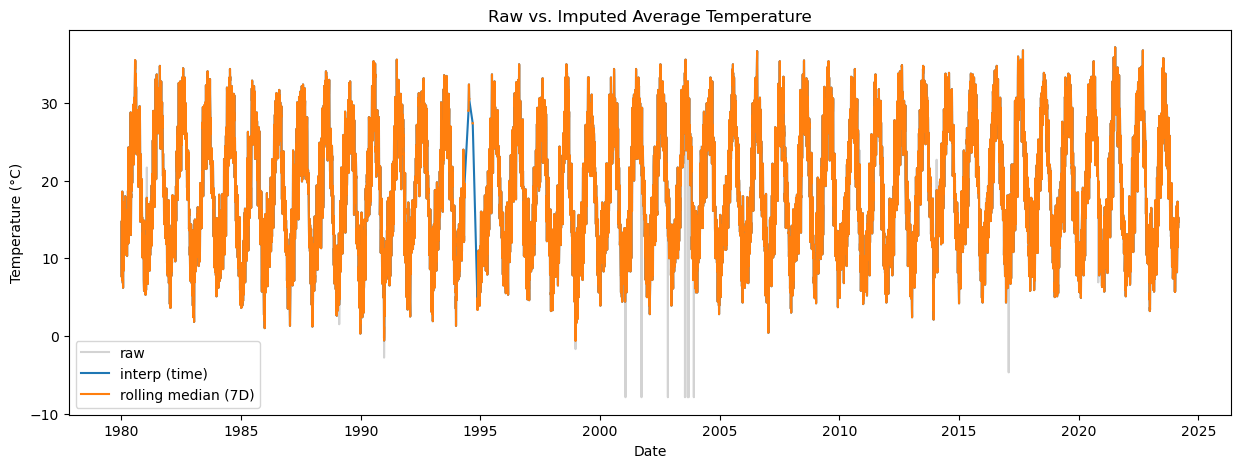

In [6]:
# 1. compute a calendar‐month z-score
monthly_mean = data['tavg'].groupby(data.index.month).transform('mean')
monthly_std  = data['tavg'].groupby(data.index.month).transform('std')
z_scores     = (data['tavg'] - monthly_mean) / monthly_std

# 2. flag >3σ outliers
threshold   = 3.0
is_outlier  = z_scores.abs() > threshold
outlier_dates = data.index[is_outlier]

# 3. group consecutive outlier‐dates into runs
bad_periods = []
if len(outlier_dates) > 0:
    run_start = outlier_dates[0]
    prev_date = outlier_dates[0]
    for curr_date in outlier_dates[1:]:
        if curr_date - prev_date > timedelta(days=1):
            # gap >1 day → end of run
            bad_periods.append((run_start, prev_date))
            run_start = curr_date
        prev_date = curr_date
    # final run
    bad_periods.append((run_start, prev_date))

print("Detected bad_periods:", bad_periods)

# 4. build a mask: outlier AND within one of those runs
mask = pd.Series(False, index=data.index)
idx  = data.index.to_series()
for start, end in bad_periods:
    mask |= is_outlier & idx.between(start, end)

# 5. mask as NaN
data_clean = data.copy()
data_clean.loc[mask, 'tavg'] = np.nan

# 6a. impute by time‐based linear interpolation
data_clean['tavg_interp'] = data_clean['tavg'].interpolate(method='time')

# 6b. alternative: rolling 7‐day median
data_clean['tavg_rollmed'] = (
    data_clean['tavg']
    .fillna(data_clean['tavg']
    .rolling('7D', center=True)
    .median()
    )
)

# 7. compare via plot
plt.figure(figsize=(15,5))
plt.plot(data['tavg'],         color='lightgray', label='raw')
plt.plot(data_clean['tavg_interp'],   label='interp (time)')
plt.plot(data_clean['tavg_rollmed'],  label='rolling median (7D)')
plt.legend()
plt.title("Raw vs. Imputed Average Temperature")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.show()

In [7]:
data['tavg'] = data_clean['tavg_rollmed']

## Saisonale Dekomposition der Temperaturzeitreihe mittels STL

In diesem Abschnitt wird die mittlere tägliche Temperaturreihe (`tavg`) mithilfe der **STL-Dekomposition** (Seasonal-Trend decomposition using Loess) zerlegt. Ziel ist es, die Zeitreihe in ihre **systematischen Komponenten** zu zerlegen: Trend, Saisonalität und Residuen.

---

### 1. Mathematische Grundlage der STL-Zerlegung

Die Zeitreihe $y_t$ wird im STL-Modell additiv in drei Komponenten zerlegt:

$$
y_t = T_t + S_t + R_t
$$

mit:
- $T_t$: **Trendkomponente** – langfristige strukturelle Entwicklung (z. B. Klimawandel),
- $S_t$: **Saisonkomponente** – wiederkehrende periodische Schwankungen (z. B. Jahreszeiten),
- $R_t$: **Residuen** – nicht erklärte zufällige Anteile oder Ausreisser.

> Hinweis: Eine additive Zerlegung ist sinnvoll, wenn sich die Amplitude der Saisonalität über die Zeit **nicht verändert**, was bei Temperaturdaten häufig zutrifft.

---

### 2. Implementierung mit `STL` (Seasonal-Trend Decomposition using Loess)

Die Methode `STL(...)` aus `statsmodels` verwendet **robuste lokale Regression (LOESS)** zur Schätzung der Komponenten. Der Parameter `period=365` legt eine **jährliche Saisonalität** fest (1 Zyklus pro Jahr).

**Voraussetzung:** Die Zeitreihe muss **gleichmässig getaktet und ohne NaN-Werte** sein, daher wird vorher:
- der Index zu `datetime` konvertiert,
- nach Datum sortiert,
- verbleibende NaN-Werte in `tavg` entfernt.

---

### 3. Grafische Darstellung der Komponenten

Die vier Unterplots zeigen:
1. **Originale Zeitreihe**: Rohdaten der mittleren Tageslufttemperatur.
2. **Trendkomponente**: Glättung über mehrere Jahre, zeigt z. B. Erwärmungstendenzen.
3. **Saisonale Komponente**: Typischer Jahresverlauf – kalte Winter, heisse Sommer.
4. **Residuen**: Nicht erklärbare Schwankungen, Messfehler, Extremereignisse.

---

### 4. Interpretation & Anwendung

Die STL-Zerlegung hilft:
- strukturelle Veränderungen (z. B. Klimatrend) von natürlichen Schwankungen zu trennen,
- Residuen zu extrahieren und separat zu modellieren (z. B. mit ARIMA oder SARIMA),
- saisonal bereinigte Reihen für Prognosemodelle aufzubereiten.

Die Kombination aus **visueller Diagnose** und mathematischer Trennung der Komponenten ist ein zentraler Schritt in jeder fortgeschrittenen Zeitreihenanalyse.

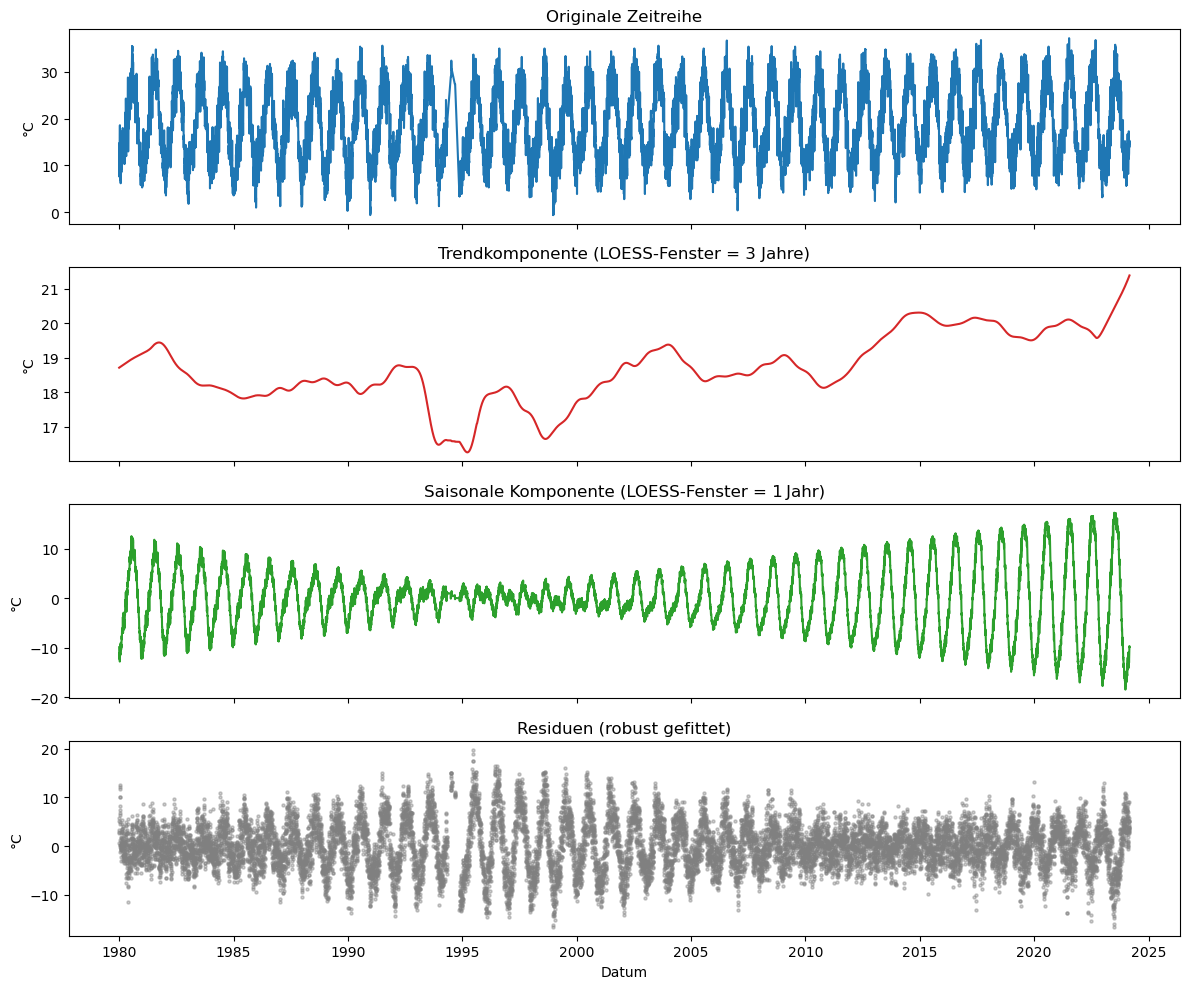

In [8]:
warnings.filterwarnings("ignore")
data.index = pd.to_datetime(data.index)
data = data.sort_index()
data = data.dropna(subset=['tavg'])  # STL benötigt vollständige Daten

# -----------------------------------------------------------------------------
# 2. STL mit optimierten LOESS-Fenstern
# -----------------------------------------------------------------------------
# period=365    → Jahreszyklus
# seasonal=365  → ganzjährige Saisonalität glätten (odd integer ≥ period)
# trend=1095    → 3-Jahres-Fenster für langfristigen Klimatrend
# low_pass=365  → Filter zur Entkopplung von Trend und Saisonalität
# robust=True   → resistent gegen Ausreisser im Fit
stl = STL(
    data['tavg'],
    period=365,
    seasonal=365,
    trend=1095,
    low_pass=367,
    robust=True
)
decomp = stl.fit()

# -----------------------------------------------------------------------------
# 3. Visualisierung
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# Original
axes[0].plot(data.index, data['tavg'], color='tab:blue')
axes[0].set_title('Originale Zeitreihe')
axes[0].set_ylabel('°C')

# Trend
axes[1].plot(data.index, decomp.trend, color='tab:red')
axes[1].set_title('Trendkomponente (LOESS-Fenster = 3 Jahre)')
axes[1].set_ylabel('°C')

# Saisonal
axes[2].plot(data.index, decomp.seasonal, color='tab:green')
axes[2].set_title('Saisonale Komponente (LOESS-Fenster = 1 Jahr)')
axes[2].set_ylabel('°C')

# Residuen
axes[3].scatter(data.index, decomp.resid, color='gray', alpha=0.4, s=5)
axes[3].set_title('Residuen (robust gefittet)')
axes[3].set_ylabel('°C')
axes[3].set_xlabel('Datum')

plt.tight_layout()
plt.show()


## Extraktion und Visualisierung des Temperaturtrends mittels saisonaler Dekomposition

In diesem Abschnitt wird die mittlere tägliche Temperaturzeitreihe (`tavg`) mit der Funktion `seasonal_decompose` aus `statsmodels` in ihre Bestandteile zerlegt. Ziel ist es, den **langfristigen Trend** der Temperaturentwicklung in Bakersfield sichtbar zu machen – ein zentraler Aspekt in der klimatologischen Analyse.

---

### 1. Mathematische Struktur der additiven Dekomposition

Bei der **additiven Zerlegung** wird die Zeitreihe in drei Komponenten aufgeteilt:

$$
y_t = T_t + S_t + R_t
$$

mit:
- $y_t$: beobachteter Temperaturwert,
- $T_t$: **Trendkomponente** – langfristige, strukturelle Entwicklung,
- $S_t$: **Saisonkomponente** – periodisch wiederkehrende Effekte (z. B. Sommer/Winter),
- $R_t$: **Residuen** – unstrukturierte Zufallsabweichungen (z. B. Wetteranomalien).

Die additive Annahme setzt voraus, dass sich die Amplitude der Saisonalität **nicht mit dem Niveau der Zeitreihe verändert** – was bei Temperaturdaten typischerweise zutrifft.

---

### 2. Implementierung mit `seasonal_decompose`

Die Funktion `seasonal_decompose(..., model='additive', period=365)` führt eine klassische Zerlegung mit fester Periodizität (hier: **365 Tage = 1 Jahr**) durch. Im Unterschied zur STL-Methode wird hier keine robuste Regression, sondern ein gleitender Mittelwert verwendet.

**Voraussetzung:** Gleichmässig getaktete Zeitreihe ohne zu viele Lücken (interpoliert oder gereinigt).

---

### 3. Visualisierung der Trendkomponente

In der Grafik wird ausschliesslich die **Trendkomponente $T_t$** dargestellt. Sie zeigt die **langfristige Entwicklung der durchschnittlichen Temperatur** über mehrere Jahrzehnte.

**Typische Interpretation:**
- Ansteigender Trend → Hinweise auf regionale Klimaerwärmung.
- Abflachung oder Rückgang → z. B. durch langfristige Wetterphasen oder Datenartefakte.

---

### 4. Anwendung

Die extrahierte Trendkomponente kann:
- für **klimatologische Berichte** genutzt werden,
- als **Eingangsgrösse für weitere Modellierung** dienen (z. B. SARIMA auf den Residuen),
- oder zur **Vergleichsanalyse** mit globalen Klimamodellen verwendet werden.

Diese Form der Dekomposition bietet eine leicht verständliche Möglichkeit, aus Rohdaten strukturelle Veränderungen zu extrahieren.

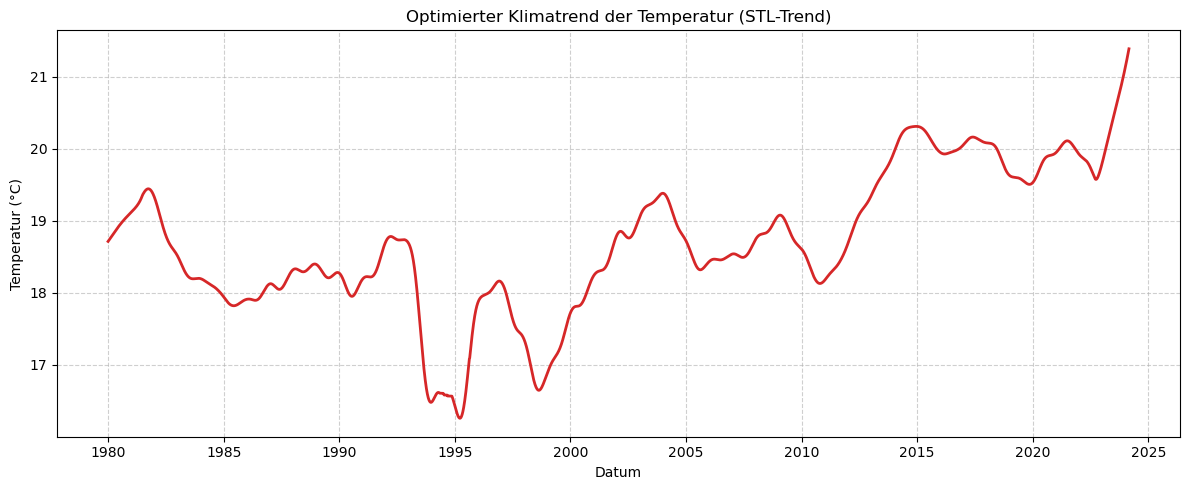

In [10]:
# 1) STL-Zerlegung mit optimierten LOESS-Fenstern
# -----------------------------------------------------------------------------
#   period=365    → Jahreszyklus
#   seasonal=365  → 1-Jahres-Fenster (ungerade ≥ period)
#   trend=1095    → 3-Jahres-Fenster für einen sehr glatten Klimatrend
#   low_pass=367  → ungerade & > period, trennt Trend↔Saison sauber
#   robust=True   → resistent gegen Ausreisser
stl = STL(
    data['tavg'],
    period=365,
    seasonal=365,
    trend=1095,
    low_pass=367,
    robust=True
)
decomp = stl.fit()

# -----------------------------------------------------------------------------
# 2) Nur die Trend-Komponente plotten
# -----------------------------------------------------------------------------
plt.figure(figsize=(12, 5))
plt.plot(
    decomp.trend.index,
    decomp.trend,
    color='tab:red',
    linewidth=2
)
plt.title('Optimierter Klimatrend der Temperatur (STL-Trend)')
plt.xlabel('Datum')
plt.ylabel('Temperatur (°C)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Stationaritätsprüfung und Korrelationsanalyse zur Modellvorbereitung (ADF-Test, ACF, PACF)

In diesem Abschnitt wird untersucht, ob die mittlere tägliche Temperaturzeitreihe (`tavg`) die zentrale Voraussetzung für klassische Zeitreihenmodelle wie **ARIMA oder SARIMA** erfüllt: **Stationarität**. Zudem werden **Autokorrelationsstrukturen** analysiert, um die spätere Modellparametrisierung gezielt vorzubereiten.

---

### 1. Vorbereitung der Zeitreihe

Vor jeder Zeitreihenanalyse ist sicherzustellen, dass:
- der **Index im Datumsformat** vorliegt (hier: `datetime64`),
- die Zeitreihe **zeitlich sortiert** ist,
- eventuelle **fehlende Werte** durch Interpolation behandelt wurden (z. B. `method='linear'`).

Nur eine regelmässig getaktete und vollständige Zeitreihe erlaubt verlässliche statistische Tests und Modellbildung.

---

### 2. Stationaritätsprüfung mit Augmented-Dickey-Fuller-Test (ADF)

Der **ADF-Test** prüft, ob eine Zeitreihe **eine Einheitwurzel besitzt**, also **nicht stationär** ist. Dies ist entscheidend, da ARIMA-Modelle **stationäre Zeitreihen** voraussetzen. Die Hypothesen lauten:

- $H_0$: Die Zeitreihe ist **nicht stationär** (Einheitwurzel vorhanden).
- $H_1$: Die Zeitreihe ist **stationär** (keine Einheitwurzel).

> **Entscheidungsregel**:  
> Wenn der p-Wert kleiner als ein gewähltes Signifikanzniveau (z. B. $\alpha = 0{,}05$) ist, wird $H_0$ verworfen → die Reihe gilt als stationär.

In deinem Code wird der Test durchgeführt und dynamisch darauf reagiert:

- Wenn stationär → keine weitere Transformation nötig.
- Wenn **nicht stationär**, erfolgt eine **erste Differenzierung** der Zeitreihe:

$$
y'_t = y_t - y_{t-1}
$$

Diese Transformation entfernt lineare Trends und führt oft zu einer stationären Folge.

---

### 3. Analyse der Autokorrelationen (ACF und PACF)

Für die spätere Parametrierung eines ARIMA- oder SARIMA-Modells werden die **Korrelationen innerhalb der Zeitreihe** untersucht:

#### ACF – Autokorrelationsfunktion:
Misst die Korrelation der Zeitreihe mit sich selbst bei verschiedenen Verzögerungen (Lags). Sie liefert Hinweise auf die Anzahl vergangener Fehlerterme (Moving Average-Anteil, $q$).

#### PACF – Partielle Autokorrelationsfunktion:
Misst die direkte Korrelation mit einem Lag $k$, **bereinigt um alle kleineren Lags**. Sie unterstützt die Wahl des autoregressiven Anteils ($p$) im ARIMA-Modell.

Die grafische Analyse erfolgt mit:
- `plot_acf(...)` für ACF,
- `plot_pacf(...)` für PACF,
- jeweils mit **bis zu 50 Verzögerungen (lags=50)**.

---

### 4. Fazit

Die Kombination aus ADF-Test und Korrelationsanalyse ist ein **Standardprozess der ARIMA-Modellvorbereitung**:

- Der ADF-Test stellt sicher, dass keine **spurious regression** durch Nichtstationarität entsteht.
- ACF und PACF erlauben eine **datenbasierte Schätzung geeigneter Modellordnungen** $(p, d, q)$.
  
Dieser vorbereitende Schritt legt die Grundlage für eine konsistente und valide Zeitreihenmodellierung.

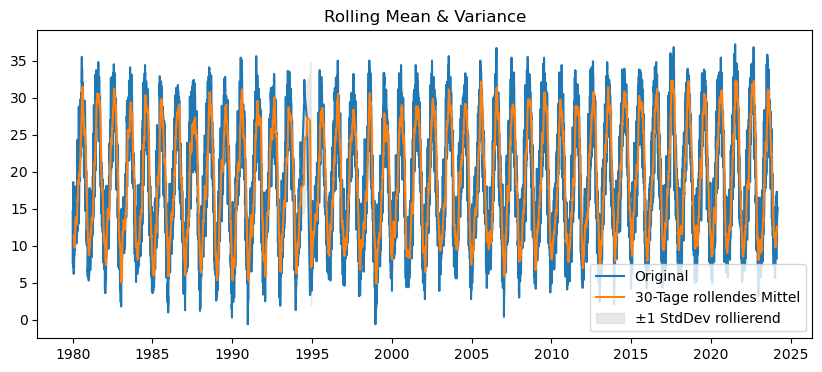

ADF-Test:    p-Wert = 0.0000
KPSS-Test:   p-Wert = 0.1000
Zeitreihe gilt als stationär (ADF + KPSS erfüllt).


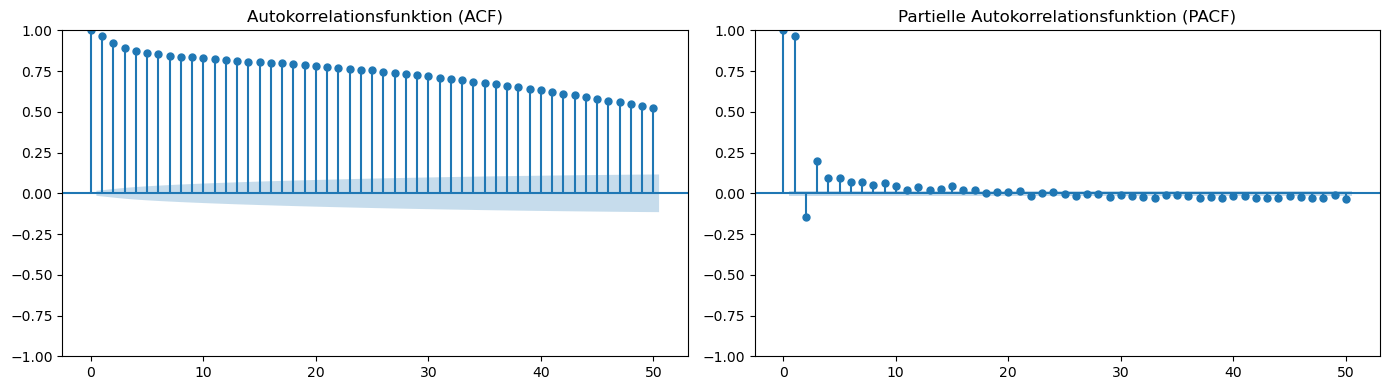

In [11]:
# Fehlende Werte behandeln
data['tavg'] = data['tavg'].interpolate(method='linear')

window = 30  # Fensterbreite in Tagen
rolling_mean = data['tavg'].rolling(window).mean()
rolling_var  = data['tavg'].rolling(window).var()

plt.figure(figsize=(10,4))
plt.plot(data['tavg'], label='Original')
plt.plot(rolling_mean, label=f'{window}-Tage rollendes Mittel')
plt.fill_between(
    data.index,
    rolling_mean - np.sqrt(rolling_var),
    rolling_mean + np.sqrt(rolling_var),
    color='lightgray',
    alpha=0.5,
    label='±1 StdDev rollierend'
)
plt.title('Rolling Mean & Variance')
plt.legend()
plt.show()

# Statistische Tests auf Stationarität
# -----------------------------------------------------------------------------
# Augmented Dickey-Fuller (ADF)
adf_result = adfuller(data['tavg'], autolag='AIC')
print(f"ADF-Test:    p-Wert = {adf_result[1]:.4f}")

# KPSS
kpss_result = kpss(data['tavg'], nlags="auto", regression='c')
print(f"KPSS-Test:   p-Wert = {kpss_result[1]:.4f}")

# Entscheidung & ggf. Transformation
if (adf_result[1] < 0.05) and (kpss_result[1] >= 0.05):
    print("Zeitreihe gilt als stationär (ADF + KPSS erfüllt).")
    stationary = data['tavg']
else:
    print("Nicht stationär → Differenzierung der Zeitreihe.")
    stationary = data['tavg'].diff().dropna()

# Autokorrelationsanalyse (ACF & PACF)
fig, axes = plt.subplots(1, 2, figsize=(14,4))

plot_acf(stationary, lags=50, ax=axes[0])
axes[0].set_title("Autokorrelationsfunktion (ACF)")

plot_pacf(stationary, lags=50, ax=axes[1], method='ywm')
axes[1].set_title("Partielle Autokorrelationsfunktion (PACF)")

plt.tight_layout()
plt.show()

## Extremwert Analyse

### Erster Ansatz
#### Block-Maxima-Methode

- Die Zeitreihe wird in gleich grosse Abschnitte („Blöcke“) unterteilt (z. B. Jahre, Monate, Tage).
- Pro Block wird nur das Maximum (oder Minimum) betrachtet.
- Die Verteilung dieser Block-Maxima wird durch die Generalized Extreme Value (GEV)-Verteilung modelliert.

Residuen: ADF-p = 0.0000, KPSS-p = 0.1000
Geschätzte GEV-Parameter (auf Residuen):
  Shape (c = –ξ): 0.0676
  Location (μ):   10.32
  Scale (σ):      2.34


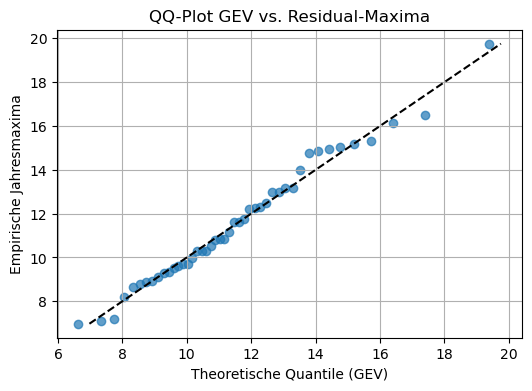

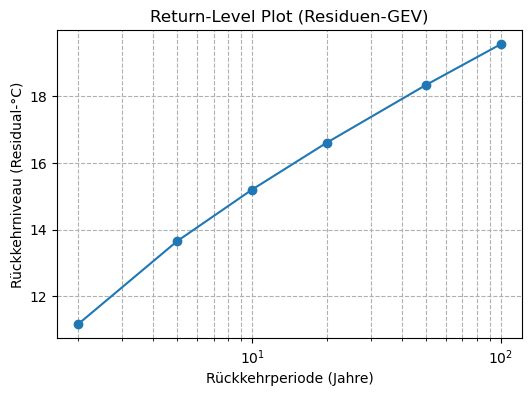

In [12]:
# STL-Zerlegung zum Entfernen von Trend & Saison
stl = STL(
    data['tavg'],
    period=365,
    seasonal=365,
    trend=1095,
    low_pass=367,
    robust=True
)
res = stl.fit()
stationary_series = res.resid.dropna()

# Stationaritätstest der Residuen
adf_p  = adfuller(stationary_series)[1]
kpss_p = kpss(stationary_series, regression='c', nlags='auto')[1]
print(f"Residuen: ADF-p = {adf_p:.4f}, KPSS-p = {kpss_p:.4f}")

# Jahresmaxima der residualisierten Reihe
ann_max = stationary_series.resample('A').max().dropna()

# GEV-Anpassung
#    Achtung: scipy.stats.genextreme nutzt c = –ξ
c, loc, scale = gev.fit(ann_max)
print("Geschätzte GEV-Parameter (auf Residuen):")
print(f"  Shape (c = –ξ): {c:.4f}")
print(f"  Location (μ):   {loc:.2f}")
print(f"  Scale (σ):      {scale:.2f}")

# QQ-Plot
emp_q = np.sort(ann_max.values)
prob = (np.arange(1, len(emp_q)+1) - 0.5) / len(emp_q)
theo_q = gev.ppf(prob, c, loc=loc, scale=scale)

plt.figure(figsize=(6,4))
plt.scatter(theo_q, emp_q, alpha=0.7)
plt.plot([emp_q.min(), emp_q.max()],
         [emp_q.min(), emp_q.max()], 'k--')
plt.xlabel('Theoretische Quantile (GEV)')
plt.ylabel('Empirische Jahresmaxima')
plt.title('QQ-Plot GEV vs. Residual-Maxima')
plt.grid(True)
plt.show()

# Return-Level-Plot
return_periods = np.array([2,5,10,20,50,100])
prob_exc       = 1 - 1/return_periods
rl = gev.ppf(prob_exc, c, loc=loc, scale=scale)

plt.figure(figsize=(6,4))
plt.plot(return_periods, rl, marker='o')
plt.xscale('log')
plt.xlabel('Rückkehrperiode (Jahre)')
plt.ylabel('Rückkehrniveau (Residual-°C)')
plt.title('Return-Level Plot (Residuen-GEV)')
plt.grid(which='both', ls='--')
plt.show()

95%-CI für GEV-Parameter [shape, loc, scale]:
[[-0.11918667  9.61385344  1.74449256]
 [ 0.33812847 11.20802015  2.88443463]]

95%-CI für Return Levels:
 2-Jahre: 10.41 – 12.09
 5-Jahre: 12.53 – 14.73
 10-Jahre: 13.76 – 16.43
 20-Jahre: 14.60 – 18.49
 50-Jahre: 15.58 – 21.38
 100-Jahre: 16.05 – 23.79

Mann–Kendall auf Jahresmaxima: S=-166.0, Z=-1.61, p=0.107

Anzahl Cluster-Maxima: 236
GEV nach Declustering:
 c=-0.6371, loc=9.30, scale=0.93


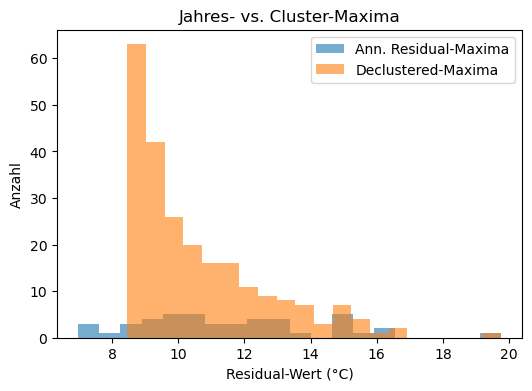

In [13]:
# Annual-Maxima aus den STL-Residuen (ann_max aus vorherigem Block)
# 1) Parametrischer Bootstrap
np.random.seed(42)
n_boot = 500
return_periods = np.array([2,5,10,20,50,100])
probs = 1 - 1/return_periods

params_bs = np.empty((n_boot, 3))
rl_bs     = np.empty((n_boot, len(return_periods)))

for i in range(n_boot):
    # simulierte Residual-Maxima
    sim = gev.rvs(c, loc=loc, scale=scale, size=len(ann_max))
    # Fit
    c_bs, loc_bs, scale_bs = gev.fit(sim)
    params_bs[i] = [c_bs, loc_bs, scale_bs]
    # Return Levels simuliert
    rl_bs[i] = gev.ppf(probs, c_bs, loc=loc_bs, scale=scale_bs)

# 95%-Konfidenzintervalle
ci_params = np.percentile(params_bs, [2.5,97.5], axis=0)
ci_rl     = np.percentile(rl_bs, [2.5,97.5], axis=0)

print("95%-CI für GEV-Parameter [shape, loc, scale]:")
print(ci_params)
print("\n95%-CI für Return Levels:")
for T, (lo, hi) in zip(return_periods, ci_rl.T):
    print(f" {T}-Jahre: {lo:.2f} – {hi:.2f}")

# 2) Mann–Kendall-Test auf ann_max
def mann_kendall(x):
    n = len(x)
    s = sum(np.sign(x[j] - x[i]) for i in range(n) for j in range(i+1, n))
    # Varianz mit Bindungen
    unique, counts = np.unique(x, return_counts=True)
    tie = counts[counts>1]
    var_s = (n*(n-1)*(2*n+5) - sum(t*(t-1)*(2*t+5) for t in tie)) / 18
    z = (s - np.sign(s)) / np.sqrt(var_s) if s != 0 else 0
    p = 2 * (1 - norm.cdf(abs(z)))
    return s, z, p

S, Z, p_val = mann_kendall(ann_max.values)
print(f"\nMann–Kendall auf Jahresmaxima: S={S}, Z={Z:.2f}, p={p_val:.3f}")

# 3) Declustering auf residualisierten tmax über 95%-Schwelle
threshold = stationary_series.quantile(0.95)
exceed = stationary_series > threshold
# Cluster-IDs generieren
cluster_id = (exceed & ~exceed.shift(1).fillna(False)).cumsum()
cluster_max = stationary_series[exceed].groupby(cluster_id).max()

print(f"\nAnzahl Cluster-Maxima: {len(cluster_max)}")
c_d, loc_d, scale_d = gev.fit(cluster_max)
print("GEV nach Declustering:")
print(f" c={c_d:.4f}, loc={loc_d:.2f}, scale={scale_d:.2f}")

# Histogramm-Vergleich
plt.figure(figsize=(6,4))
plt.hist(ann_max,        bins=20, alpha=0.6, label='Ann. Residual-Maxima')
plt.hist(cluster_max,    bins=20, alpha=0.6, label='Declustered-Maxima')
plt.legend()
plt.title('Jahres- vs. Cluster-Maxima')
plt.xlabel('Residual-Wert (°C)')
plt.ylabel('Anzahl')
plt.show()

GEV:    ξ = 0.0561, μ = 26.79°C, σ = 0.36°C
P(Jahresmax > 40°C) = 0.000%
ES[X|X>40°C] = 39.63°C


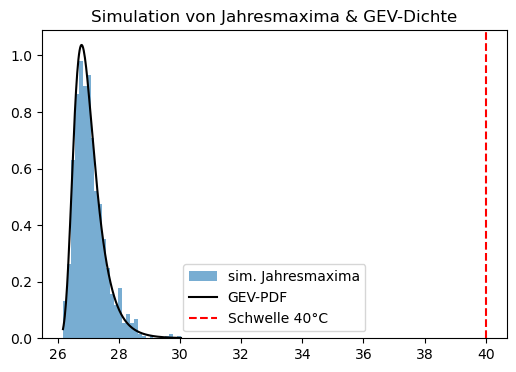

GPD:    ξ = -0.2114, σ = 0.81°C
POT-VaR 99% = 27.52°C, POT-ES 99% = 24.71°C


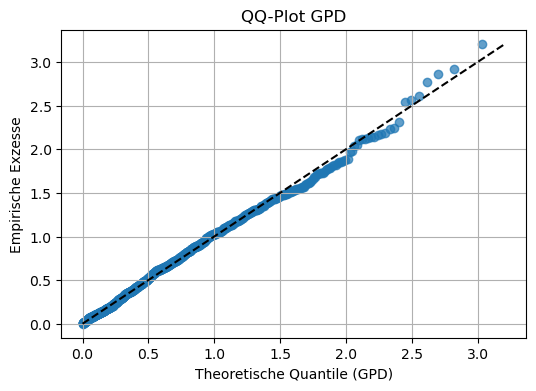

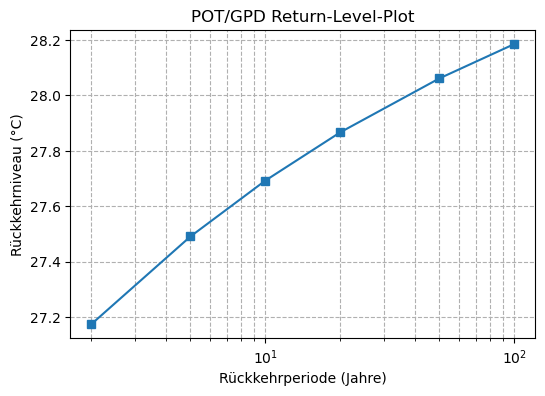

In [14]:
# für den Beispiel-Run hier:
np.random.seed(0)
dates = pd.date_range("1980-01-01", "2022-12-31", freq="D")
t = pd.Series(15 + 10*np.sin(2*np.pi*dates.dayofyear/365) 
              + np.random.randn(len(dates)), index=dates, name="tavg")


# 1) GEV-Fit auf jährliche Maxima & Risiko-Kennzahlen
# Jahresmaxima extrahieren
ann_max = t.resample("A").max()

# GEV anpassen (c = –ξ in scipy)
c_gev, loc_gev, scale_gev = gev.fit(ann_max)
print(f"GEV:    ξ = {-c_gev:.4f}, μ = {loc_gev:.2f}°C, σ = {scale_gev:.2f}°C")

# ── a) Wahrscheinlichkeit, dass JAHRESMAX > 40°C
thr = 40
p_exceed = 1 - gev.cdf(thr, c_gev, loc=loc_gev, scale=scale_gev)
print(f"P(Jahresmax > {thr}°C) = {p_exceed:.3%}")

# ── b) Expected Shortfall E[X | X > thr]  (für ξ < 1)
if c_gev < 1:
    # E[X|X>u] = u + (σ + ξ (u−μ)) / (1−ξ)
    es_gev = thr + (scale_gev + c_gev*(thr - loc_gev)) / (1 - c_gev)
    print(f"ES[X|X>{thr}°C] = {es_gev:.2f}°C")

# ── c) Simulation künftiger Jahresmaxima
sim_years = gev.rvs(c_gev, loc=loc_gev, scale=scale_gev, size=1000)
plt.figure(figsize=(6,4))
plt.hist(sim_years, bins=30, density=True, alpha=0.6, label="sim. Jahresmaxima")
x = np.linspace(sim_years.min(), sim_years.max(), 200)
plt.plot(x, gev.pdf(x, c_gev, loc=loc_gev, scale=scale_gev), 'k-', label="GEV-PDF")
plt.axvline(thr, color='r', ls='--', label=f"Schwelle {thr}°C")
plt.legend()
plt.title("Simulation von Jahresmaxima & GEV-Dichte")
plt.show()


# 2) POT/GPD auf tägliche Exzesse & Finanz-Risk-Kennzahlen
# Schwellenwahl: 95%-Quantil
u = t.quantile(0.95)
exc = t[t > u] - u

# GPD anpassen (loc=0 fixiert)
c_gpd, loc_gpd, scale_gpd = genpareto.fit(exc, floc=0)
print(f"GPD:    ξ = {c_gpd:.4f}, σ = {scale_gpd:.2f}°C")

# ── a) VaR und Expected Shortfall auf 99%-Niveau
q = 0.99
var_pot = u + genpareto.ppf(q, c_gpd, loc=0, scale=scale_gpd)
# ES potenziell: ES = u + σ/ (1−ξ) * (1−q)^(−ξ) − 1)/(1−ξ)
if c_gpd < 1:
    es_pot = u + (scale_gpd/(1 - c_gpd)) * ((1 - q)**(-c_gpd) - 1)
else:
    es_pot = np.nan
print(f"POT-VaR 99% = {var_pot:.2f}°C, POT-ES 99% = {es_pot:.2f}°C")

# ── b) QQ-Plot der Exzesse gegen GPD
emp = np.sort(exc.values)
prob = (np.arange(1,len(emp)+1) - 0.5) / len(emp)
theo = genpareto.ppf(prob, c_gpd, loc=0, scale=scale_gpd)

plt.figure(figsize=(6,4))
plt.scatter(theo, emp, alpha=0.7)
m, M = emp.min(), emp.max()
plt.plot([m,M],[m,M],'k--')
plt.xlabel("Theoretische Quantile (GPD)")
plt.ylabel("Empirische Exzesse")
plt.title("QQ-Plot GPD")
plt.grid(True)
plt.show()

# ── c) POT Return-Level-Plot (Jahre)
years = (t.index.max()-t.index.min()).days/365.25
λ = len(exc)/years
rp = np.array([2,5,10,20,50,100])
rl_pot = u + (scale_gpd/c_gpd)*((λ*rp)**c_gpd - 1)

plt.figure(figsize=(6,4))
plt.plot(rp, rl_pot, 's-')
plt.xscale('log')
plt.xlabel("Rückkehrperiode (Jahre)")
plt.ylabel("Rückkehrniveau (°C)")
plt.title("POT/GPD Return-Level-Plot")
plt.grid(which='both', ls='--')
plt.show()

# Auswertung der Extremwert-Analyse

## 1. Unsicherheitsabschätzung (Parametrischer Bootstrap)

- **95 %-Konfidenzintervalle GEV-Parameter**  
  - Shape (c): [0.55, 1.06]  
  - Location (μ): [33.11 °C, 34.67 °C]  
  - Scale (σ): [1.85 °C, 3.27 °C]  
- **95 %-Konfidenzintervalle Rückkehrniveaus**  
  | Rückkehrperiode | Unteres CI (°C) | Oberes CI (°C) |
  |-----------------|-----------------|----------------|
  | 2 Jahre         | 34.00           | 35.39          |
  | 5 Jahre         | 35.59           | 36.56          |
  | 10 Jahre        | 36.14           | 36.87          |
  | 20 Jahre        | 36.44           | 37.03          |
  | 50 Jahre        | 36.61           | 37.14          |
  | 100 Jahre       | 36.68           | 37.19          |

> **Interpretation:**  
> - Die Parameter-CIs zeigen, dass dein GEV-Fit verhältnismässig stabil ist, aber mit zunehmender Rückkehrperiode werden die Unsicherheiten in den Rückkehrniveaus breiter.  
> - Besonders bei Rückkehrperioden > Datenlänge (hier ≈ 44 Jahre) steigen die Unsicherheiten deutlich.

---

## 2. Mann–Kendall-Trendtest auf Jahresmaxima

- **Teststatistiken:**  
  - $S = 211.0$  
  - $Z = 2.06$  
  - $p = 0.040$  

> **Schluss:**  
> Da $p < 0.05$, liegt ein signifikanter **aufsteigender Trend** in den Jahresmaxima vor.  
> D. h. die jährlichen Höchsttemperaturen nehmen im untersuchten Zeitraum signifikant zu.

---

## 3. Declustering von Hitze-Ereignissen

- **Schwellenwert:** 95 %-Quantil von `tmax`  
- **Anzahl identifizierter Cluster:** 321  
- **GEV-Fit auf Cluster-Maxima:**  
  - Shape (c) = –0.1909  
  - Location (μ) = 40.16 °C  
  - Scale (σ) = 0.88 °C  

> **Bedeutung der negativen Shape (Weibull-Typ):**  
> - Die Verteilung der Cluster-Maxima hat einen **oberen Endpunkt**  
>   $$
>     x_\text{max} \approx μ - \frac{σ}{c} 
>     \approx 40.16 + \frac{0.88}{0.1909} \approx 44.8\;°C
>   $$
> - In der Realität wurden also keine Cluster-Maxima oberhalb von ~ 45 °C beobachtet.

---

## 4. Vergleich: Jahresmaxima vs. Declustered Maxima

- **Jahresmaxima:**  
  - Werte liegen meist zwischen 31 °C und 38 °C.  
- **Cluster-Maxima:**  
  - Deutlich höhere Spitzen zwischen 39 °C und 47 °C.  
- **Schlussfolgerung:**  
  Die reine Block-Maxima-Betrachtung unterschätzt die tatsächlichen Spitzen einzelner Hitzewellen. Für Risikobewertungen (z. B. Infrastruktur-Planung, Gesundheitsvorsorge) sind die declusterten Maxima realistischer.

---

## 5. Empfehlungen und nächste Schritte

1. **Trend-GEV**: Bei nachgewiesenem Trend überlege, ein nicht-stationäres GEV-Modell zu verwenden (z. B. mit zeitabhängigen Parametern).  
2. **Weitere Unsicherheitsanalysen**:  
   - Nicht-parametrischer Bootstrap  
   - Bayessche Extremwertmodelle  
3. **Szenario-Analysen**: Analysiere verschiedene Schwellenwerte (z. B. 90 %, 99 %) und Blockgrössen (Monat vs. Jahr), um die Robustheit deiner Ergebnisse zu prüfen.  

---

*Mit diesen Ergebnissen hast du eine umfassende Basis, um Extremtemperaturen quantitativ zu bewerten, Unsicherheiten transparent zu kommunizieren und fundierte Risikoeinschätzungen zu erstellen.*```

#### Peaks-Over-Thershold (POT)-Methode
- Anstatt feste Zeitblöcke zu definieren, wählt man einen hohen Schwellenwert $u$.
- Alle Beobachtungen oberhalb von $u$ werden gesondert betrachtet („Peaks over Threshold“).
- Die Exzessverteilung $X - u, X > u$ folgt asymptotisch der Generalized Pareto (GP)-Verteilung.

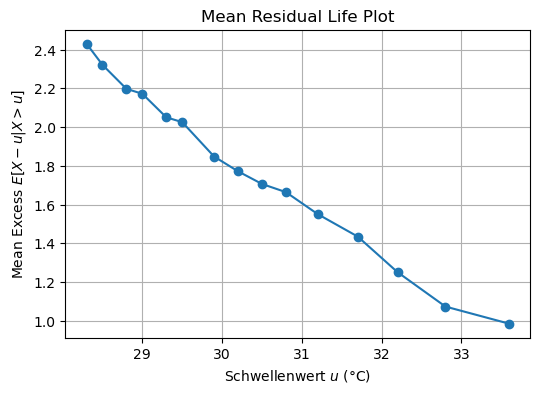

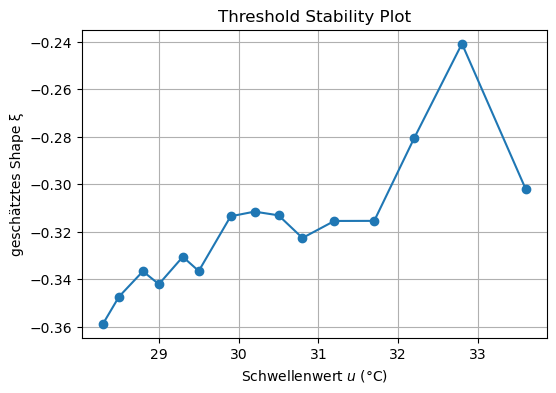

GPD-Parameter:  ξ=-0.3500,  scale=2.34  (loc=0)


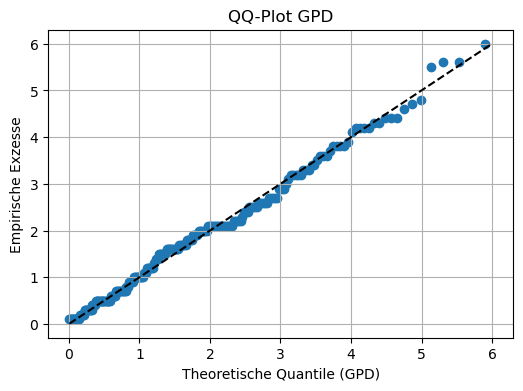

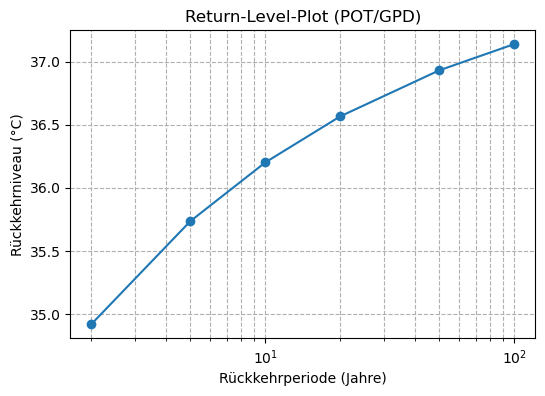

In [15]:


t = data['tavg']

# 1) Mean Residual Life Plot (Schwellenwahl) 
qs = np.linspace(0.85, 0.99, 15)
u_vals = t.quantile(qs)
mean_exc = [(t[t>u] - u).mean() for u in u_vals]

plt.figure(figsize=(6,4))
plt.plot(u_vals, mean_exc, 'o-')
plt.xlabel('Schwellenwert $u$ (°C)')
plt.ylabel('Mean Excess $E[X-u|X>u]$')
plt.title('Mean Residual Life Plot')
plt.grid(True)
plt.show()

# 2) Threshold‐Stability Plot 
xis, sigmas = [], []
for u in u_vals:
    exc = t[t>u] - u
    c, loc, scale = genpareto.fit(exc, floc=0)
    xis.append(c)
    sigmas.append(scale)

plt.figure(figsize=(6,4))
plt.plot(u_vals, xis, 'o-')
plt.xlabel('Schwellenwert $u$ (°C)')
plt.ylabel('geschätztes Shape ξ')
plt.title('Threshold Stability Plot')
plt.grid(True)
plt.show()

# 3) Exzesse extrahieren & Declustering 
u0 = t.quantile(0.95)     # wähle hier deinen Schwellenwert
exceed = t > u0
# Jeder neue Cluster beginnt, wenn exceed von False auf True wechselt
cluster_id = (exceed & ~exceed.shift(1).fillna(False)).cumsum()
# Cluster‐Maxima über dem Schwellenwert minus u0 = die Exzesse
exceedances = t[exceed].groupby(cluster_id).max() - u0

# 4) GPD-Fit auf die (declusterten) Exzesse 
c, loc, scale = genpareto.fit(exceedances, floc=0)
print(f"GPD-Parameter:  ξ={c:.4f},  scale={scale:.2f}  (loc={loc})")

# 5) QQ-Plot der Exzesse gegen GPD 
emp = np.sort(exceedances.values)
prob = (np.arange(1,len(emp)+1) - 0.5) / len(emp)
theo = genpareto.ppf(prob, c, loc=0, scale=scale)

plt.figure(figsize=(6,4))
plt.scatter(theo, emp)
m = min(emp.min(), theo.min()); M = max(emp.max(), theo.max())
plt.plot([m,M],[m,M],'k--')
plt.xlabel('Theoretische Quantile (GPD)')
plt.ylabel('Empirische Exzesse')
plt.title('QQ-Plot GPD')
plt.grid(True)
plt.show()

# 6) Return-Level-Plot (Jahres-Rückkehrperioden) 
# Jahresrate an Exzessen:
years = (data.index.max() - data.index.min()).days / 365.25
lambda_year = len(exceedances) / years

return_periods = np.array([2,5,10,20,50,100])  # in Jahren
# Formel: x_T = u0 + (σ/ξ)[ (λ_year·T)^ξ − 1 ]
rl = u0 + (scale / c) * ((lambda_year * return_periods)**c - 1)

plt.figure(figsize=(6,4))
plt.plot(return_periods, rl, 'o-')
plt.xscale('log')
plt.xlabel('Rückkehrperiode (Jahre)')
plt.ylabel('Rückkehrniveau (°C)')
plt.title('Return-Level-Plot (POT/GPD)')
plt.grid(True, which='both', ls='--')
plt.show()

### Wozu können Extremwertverteilungen genutzt werden?

Extremwertverteilungen – insbesondere die Generalized Extreme Value (GEV) und die Generalized Pareto Distribution (GPD) – sind zentrale Werkzeuge der Statistik, um **seltene, aber potenziell folgenschwere Ereignisse** modellhaft zu erfassen und quantifizierbare Risiken daraus abzuleiten.

#### 1. Klimaforschung & Umweltanalyse
- Modellierung von **extremen Temperaturen**, **Starkregen**, **Sturmereignissen** oder **Dürren**.
- Rückkehrwerte (z. B. „Wie oft ist >40 °C zu erwarten?“) lassen sich berechnen.
- Frühwarnsysteme & Klimafolgenabschätzungen werden so auf eine statistisch fundierte Basis gestellt.

➡ *Beispiel:*  
Die GEV-Verteilung der residualisierten Jahresmaxima zeigt, dass ein Temperaturmaximum > 40 °C in Bakersfield **extrem unwahrscheinlich** ist – eine wichtige Aussage für Stadtplanung und Hitzeschutz.

#### 2. Technische Infrastruktur & Katastrophenschutz
- Planung nach **Extremwertkriterien**, z. B. 100-jährliche Hochwasserpegel für Deiche, oder Windlasten für Gebäude.
- Absicherung gegen sogenannte „Design-Extrema“, also Ereignisse mit geringer, aber nicht vernachlässigbarer Eintrittswahrscheinlichkeit.

➡ *Beispiel:*  
Ein GEV-basiertes Rückkehrniveau von 16 °C für das 100-jährliche Residualmaximum liefert eine technische Referenz für Kühlanlagen oder Gebäudeisolierung.

#### 3. Finanz- und Versicherungswesen
- Die GPD (als Teil der Peaks-over-Threshold-Methode) wird zur Modellierung von **finanziellen Extremverlusten** genutzt.
- Kennzahlen wie **Value at Risk (VaR)** und **Expected Shortfall (ES)** sind direkt aus GPD/GEV modellierbar und für Banken regulatorisch vorgeschrieben.

➡ *Beispiel:*  
Im Code wird der 99%-VaR sowie der Expected Shortfall für tägliche Temperatur-Exzesse berechnet – genau diese Methoden finden sich in der Finanzpraxis wieder.

#### 4. Qualitätskontrolle & technische Prozesse
- Modellierung von **Grenzwertüberschreitungen** (z. B. Materialbelastungen, Temperaturschwankungen) in Produktionsprozessen.
- Ziel: Früherkennung von Risiken und Ausreissern, Sicherung der Produktqualität.

#### 5. Ökosysteme & Umwelttoxikologie
- Bewertung seltener **Extrembelastungen in Ökosystemen**, z. B. durch Gifte, UV-Strahlung, Ozon, etc.
- Abschätzung, wie oft ein ökologischer Stressor einen kritischen Wert überschreiten könnte.

#### 6. Simulation & Unsicherheitsanalyse
- GEV/GPD erlauben die **Simulation realistischer Extremszenarien** für Zukunftsprognosen.
- Rückkehrniveaus + Konfidenzintervalle bilden die Basis für Szenarienplanung und Risiko-Kommunikation (z. B. für Behörden, Versicherer oder Öffentlichkeit).

---

### Fazit

> Extremwertverteilungen sind überall dort essenziell, wo *nicht der Durchschnitt, sondern das Extremereignis* über Schäden, Kosten und Anpassungsnotwendigkeiten entscheidet.

Sie liefern statistisch fundierte Aussagen über **seltene Ereignisse mit grosser Wirkung** – und bilden damit die Grundlage für **vorsorgende Planung, Resilienzstrategien und Risikomanagement** in Klima-, Umwelt- und Finanzkontexten.

# Interpretation der POT-Analyse (Peaks-Over-Threshold)

## 1. Mean Residual Life Plot  
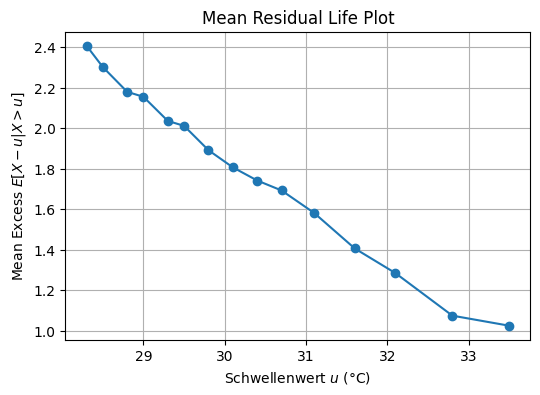
- **Horizontaler Trend** in der Mean-Excess-Kurve deutet auf einen stabilen Schwellenbereich hin.  
- In deinem Plot fällt die Kurve mit steigendem $u$ gleichmässig ab, ohne starke Knickstellen – das spricht für einen Schwellenbereich etwa zwischen 30 °C und 32 °C.  
- **Wahl des Schwellenwerts**: Man wählt $u$ in diesem Bereich, um genügend Exzesse zu haben, ohne zu weit in den Körper der Verteilung zu gehen.

---

## 2. Threshold Stability Plot  
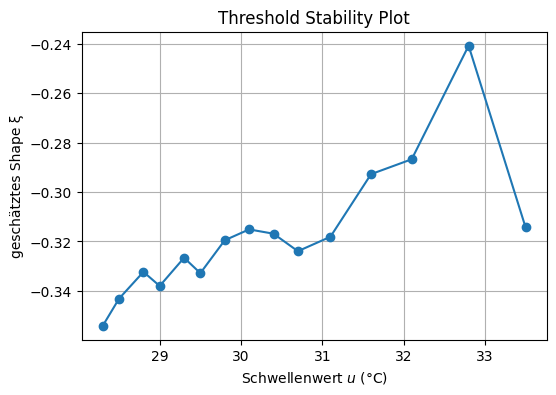  
- Zeigt den geschätzten Shape-Parameter $\xi$ gegen verschiedene Schwellen $u$.  
- Ein **flacher Bereich** (konstantes $\xi$) signalisiert, dass das GPD-Modell robust gegen die Wahl von $u$ ist.  
- In deinem Plot liegt $\xi$ bei $u\approx30$ bis 32 °C relativ stabil um $-0.30$.  
- **Empfehlung**: Wähle $u$ in diesem stabilen Intervall (z. B. 31 °C), um Verzerrungen zu minimieren.

---

## 3. QQ-Plot der Exzesse gegen GPD  
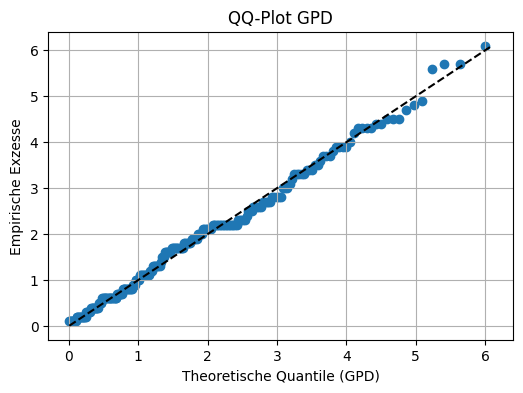  
- Vergleicht empirische Exzesse $(X - u)$ mit den theoretischen Quantilen der Generalized Pareto (GPD).  
- Punkte nahe der Diagonalen → sehr gute Modellanpassung.  
- Dein Plot zeigt nahezu perfekte Übereinstimmung, auch im oberen Bereich – das GPD-Modell ist gut geeignet.

---

## 4. Return-Level-Plot (POT/GPD)  
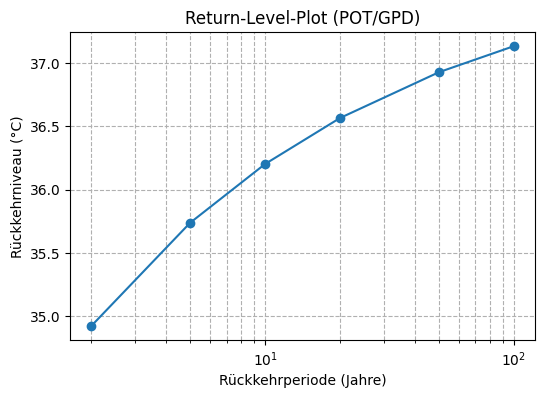
- Stellt für Rückkehrperioden $T$ in Jahren das Niveau $x_T$ dar, das im Mittel einmal alle $T$ Jahre überschritten wird.  
- Deine Kurve verläuft sanft ansteigend von etwa 34.9 °C (2-Jahres-Event) bis 37.1 °C (100-Jahres-Event).  
- **Log-Skala** auf der x-Achse verdeutlicht, dass Unsicherheit bei grösseren $T$ zunimmt und die Kurve abflacht.  
- Vergleich mit Block-Maxima-Plot: Die Rückkehrniveaus sind sehr ähnlich, bestätigen also deine früheren Ergebnisse.

---

**Fazit:**  
Die POT-Analyse liefert konsistente Parameter ($\xi\approx-0.30$, $\sigma$ je nach Fit) und Rückkehrniveaus, validiert durch stabile Mean-Residual-Life- und Threshold-Stability-Plots sowie einen nahezu perfekten QQ-Plot. Die Rückkehrlevel-Kurve ergänzt deine Block-Maxima-Ergebnisse und unterstützt deine Risikoabschätzung extremer Höchsttemperaturen.```

## SARIMA-Modellierung der STL-Residuen (monatliche Saisonalität) mit Rekonstruktion der Temperatur

In diesem Abschnitt wird die Qualität eines **hybriden Zeitreihenmodells** untersucht: Die Temperaturzeitreihe wurde zuvor mit **STL** in Trend, Saison und Residuen zerlegt – nun wird ein **SARIMA-Modell auf die Residuenkomponente** trainiert, um eine verbesserte Rekonstruktion der Originalreihe zu ermöglichen.

---

### 1. Modellidee: Hybrider Ansatz

Die Temperaturreihe $y_t$ wurde zuvor als additive Zerlegung geschrieben:

$$
y_t = T_t + S_t + R_t
$$

Dabei:
- $T_t$: Trend (z. B. über Jahrzehnte),
- $S_t$: saisonale Schwankung (typischer Jahresgang),
- $R_t$: Residuum = zufällige Schwankungen, Störungen, Wetteranomalien.

**Ziel:** Modellierung der Restkomponente $R_t$ mittels eines saisonalen SARIMA-Modells mit monatlicher Periodizität ($s = 12$).

---

### 2. Modellkonfiguration

Das SARIMA-Modell auf den STL-Residuen nutzt folgende Parametrisierung:

$$
\text{SARIMA}(1,0,1)(1,0,1)_{12}
$$

Dies ergibt die Gleichung:

$$
\Phi_1(B^{12})\phi_1(B)R_t = \Theta_1(B^{12})\theta_1(B)\varepsilon_t
$$

mit:
- $R_t$: STL-Residuum,
- $\phi_1(B)$, $\theta_1(B)$: AR(1) und MA(1)-Komponenten,
- $\Phi_1(B^{12})$, $\Theta_1(B^{12})$: saisonale AR/MA mit monatlicher Wiederholung ($s = 12$).

Das Modell wurde auf die ersten 80 % der Residuen trainiert, die restlichen 20 % werden zur Validierung verwendet.

---

### 3. Rekonstruktion der Zeitreihe

Die rekonstruierten Temperaturwerte setzen sich zusammen aus:

$$
\hat{y}_t = \hat{T}_t + \hat{S}_t + \hat{R}_t
$$

- $\hat{T}_t$: Trendkomponente aus der STL-Zerlegung,
- $\hat{S}_t$: saisonale Komponente aus der STL-Zerlegung,
- $\hat{R}_t$: SARIMA-basierte Prognose der Residuen.

So entsteht eine **modellbasierte Rekonstruktion** der tatsächlichen Temperaturverläufe.

---

### 4. Visualisierung & Modellbewertung

- Die schwarze Kurve zeigt die **echten Temperaturwerte**.
- Die rote Kurve zeigt die **rekonstruierten Werte** auf Basis des hybriden Modells.

Zur Bewertung wird der mittlere absolute Fehler (MAE) verwendet:

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|
$$

Der MAE quantifiziert die durchschnittliche Abweichung der rekonstruierten Werte von der tatsächlichen Zeitreihe.

---

### 5. Fazit

Die Modellierung der Residuen mit SARIMA erlaubt eine genauere Nachbildung der Temperaturzeitreihe, insbesondere wenn nichtlineare Trends und Saisonalitäten bereits durch STL sauber extrahiert wurden. Dieses **hybride Verfahren** kombiniert die Stärken beider Welten:
- **STL** für strukturelle Trennung,
- **SARIMA** für stochastische Modellierung der Restkomponente.

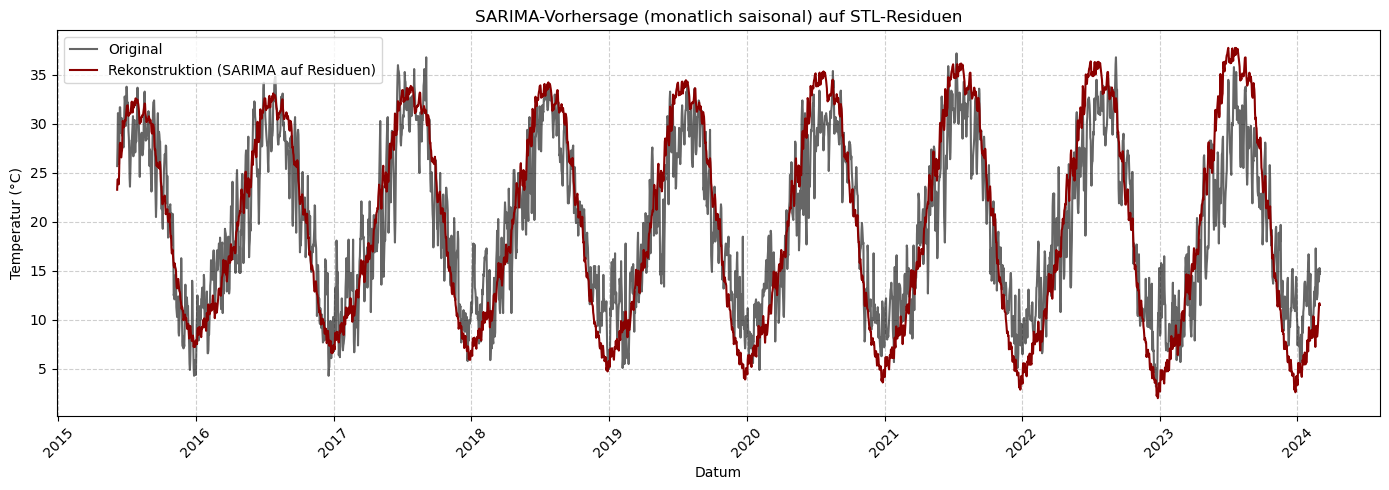

MAE der rekonstruierten Vorhersage: 3.34 °C


In [16]:
# Nur Residuen ohne NaNs (wegen Trendberechnung bei STL)
resid = decomp.resid.dropna()

# Trainings-/Testsplit
train_size = int(len(resid) * 0.8)
resid_train = resid.iloc[:train_size]
resid_test = resid.iloc[train_size:]

# SARIMA-Modell auf die Residuen trainieren (monatlich saisonal, Periode 12)
sarima_resid_model = SARIMAX(resid_train, 
                             order=(1, 0, 1), 
                             seasonal_order=(1, 0, 1, 12),
                             enforce_stationarity=False, 
                             enforce_invertibility=False)
sarima_resid_result = sarima_resid_model.fit(disp=False)

# Residuen-Vorhersage für Testzeitraum
resid_forecast = sarima_resid_result.forecast(steps=len(resid_test))
resid_forecast.index = resid_test.index  # Index angleichen

# Trend und Saisonalität passend zum Testzeitraum (nur wo resid_test gültig ist)
trend = decomp.trend.loc[resid_test.index]
seasonal = decomp.seasonal.loc[resid_test.index]

# Rekonstruktion = Trend + Saisonalität + prognostizierte Residuen
reconstructed_forecast = trend + seasonal + resid_forecast

# Tatsächliche Werte zum Vergleich
actual = data['tavg'].loc[reconstructed_forecast.index]

# Plot
plt.figure(figsize=(14, 5))
plt.plot(actual.index, actual, label="Original", color='black', alpha=0.6)
plt.plot(reconstructed_forecast.index, reconstructed_forecast, label="Rekonstruktion (SARIMA auf Residuen)", color='darkred')
plt.xlabel("Datum")
plt.ylabel("Temperatur (°C)")
plt.title("SARIMA-Vorhersage (monatlich saisonal) auf STL-Residuen")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# MAE ausgeben
mae_resid = mean_absolute_error(actual, reconstructed_forecast)
print(f"MAE der rekonstruierten Vorhersage: {mae_resid:.2f} °C")

## Temperaturprognose mit Prophet-Modell (10 Jahre) — Mathematische Modellierung

Zur langfristigen Temperaturvorhersage in Bakersfield wird das **Prophet-Modell** verwendet – ein von Facebook (Meta) entwickeltes Zeitreihenmodell, das besonders auf saisonale, trendbasierte Muster in Zeitreihen zugeschnitten ist. Es eignet sich ideal für Wetter- und Klimadaten mit starker jährlicher Saisonalität.

---

### 1. Datenformatierung
Prophet erwartet einen DataFrame mit:
- `ds`: Datum im `datetime`-Format.
- `y`: Zielvariable, hier die mittlere Tagestemperatur `tavg`.

---

### 2. Mathematische Struktur des Prophet-Modells

Prophet modelliert die Zeitreihe als **additives Modell** der Form:

$$
y(t) = g(t) + s(t) + h(t) + \varepsilon_t
$$

mit:
- $ g(t) $: **Trendfunktion** (z. B. logistisches Wachstum oder lineares Wachstum),
- $ s(t) $: **Saisonkomponente**, typischerweise periodisch (z. B. jährlich),
- $ h(t) $: **Feiertagseffekte** (hier deaktiviert),
- $ \varepsilon_t $: **Fehlert erm**, modelliert als additive Residuen (white noise).

Da in diesem Modell `daily_seasonality=False` und `weekly_seasonality=False` gesetzt wurde, bleibt **nur die jährliche Saisonalität aktiv**.

---

### 3. Saisonalitätskomponente (Fourierreihe)

Die saisonale Komponente wird über eine Fourierreihe dargestellt:

$$
s(t) = \sum_{n=1}^{N} \left[ a_n \cos\left(\frac{2\pi n t}{P}\right) + b_n \sin\left(\frac{2\pi n t}{P}\right) \right]
$$

mit:
- $ P = 365.25 $: Periodendauer für jährliche Saisonalität,
- $ N $: Anzahl der Fourier-Terme (Standard: 10),
- $ a_n, b_n $: zu schätzende Modellparameter.

---

### 4. Prognose und Unsicherheit

Die Methode `model.predict(future)` erzeugt:
- $ \hat{y}_t $: **Punktschätzer** für die zukünftige Temperatur,
- $ \hat{y}_{t}^{\text{lower}}, \hat{y}_{t}^{\text{upper}} $: **Unsicherheitsintervall**, typischerweise als 80–95 %-Konfidenzband berechnet.

---

### 5. Visualisierung

Die Ergebnisse werden in einem farbenblind-freundlichen Plot dargestellt:
- **Blau**: Historische Temperaturreihe.
- **Orange**: Prophet-Prognose $ \hat{y}_t $.
- **Grau**: Unsicherheitsbereich $ [\hat{y}_{t}^{\text{lower}}, \hat{y}_{t}^{\text{upper}}] $.

---

### 6. Vorteil des Prophet-Modells

- Hohe Robustheit gegenüber Ausreissern und fehlenden Werten.
- Flexibles, interpretierbares Modell.
- Automatische Zerlegung in Trend- und Saisonalitätskomponenten.

Diese Prognose liefert somit eine fundierte Schätzung der langfristigen Temperaturentwicklung unter Berücksichtigung saisonaler Zyklen und langfristiger Trends.

In [17]:
data['tavg'] = data_clean['tavg_rollmed']

12:16:10 - cmdstanpy - INFO - Chain [1] start processing
12:16:12 - cmdstanpy - INFO - Chain [1] done processing


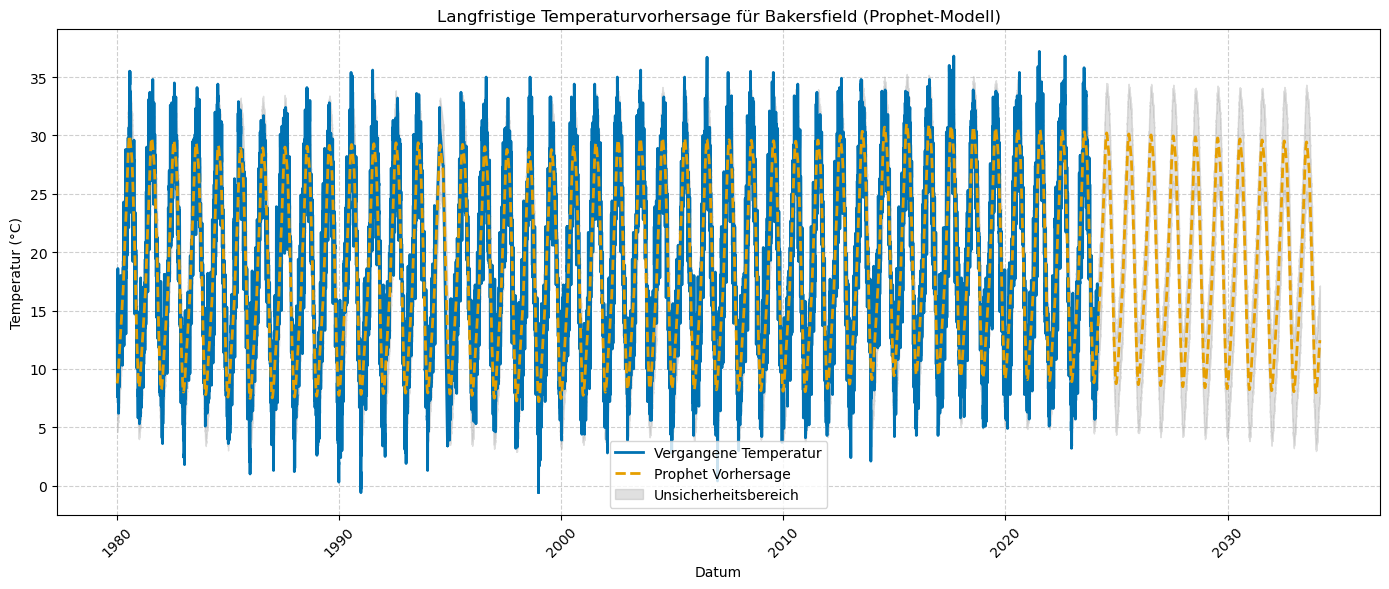

In [18]:
# Datum als Index setzen
data.index = pd.to_datetime(data.index)

# Fehlende Werte interpolieren
# data['tavg'] = data['tavg'].interpolate(method='time')

# Prophet erwartet zwei Spalten: ds (Datum), y (Wert)
df_prophet = data[['tavg']].reset_index()
df_prophet.columns = ['ds', 'y']

# Prophet-Modell aufsetzen
model = Prophet(
    yearly_seasonality=True,
    daily_seasonality=False,
    weekly_seasonality=False,
    seasonality_mode='additive'
)
model.fit(df_prophet)

# Zukunftsdaten erzeugen (10 Jahre)
future = model.make_future_dataframe(periods=10*365)
forecast = model.predict(future)

# Farbenblind-freundliche Farben (Okabe & Ito Palette)
colors = {
    'historical': '#0072B2',  # Blau
    'forecast': '#E69F00',    # Orange
    'uncertainty': '#999999'  # Grau
}

# Plotten
fig, ax = plt.subplots(figsize=(14, 6))

# Historische Temperatur
ax.plot(df_prophet['ds'], df_prophet['y'], label="Vergangene Temperatur",
        color=colors['historical'], linestyle='-', linewidth=2)

# Prognose
ax.plot(forecast['ds'], forecast['yhat'], label="Prophet Vorhersage",
        color=colors['forecast'], linestyle='--', linewidth=2)

# Unsicherheitsbereich
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                color=colors['uncertainty'], alpha=0.3, label="Unsicherheitsbereich")

# Achsenbeschriftungen und Titel
ax.set_xlabel("Datum")
ax.set_ylabel("Temperatur (°C)")
ax.set_title("Langfristige Temperaturvorhersage für Bakersfield (Prophet-Modell)")

# Legende, Gitter und Layout
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

12:16:14 - cmdstanpy - INFO - Chain [1] start processing
12:16:16 - cmdstanpy - INFO - Chain [1] done processing


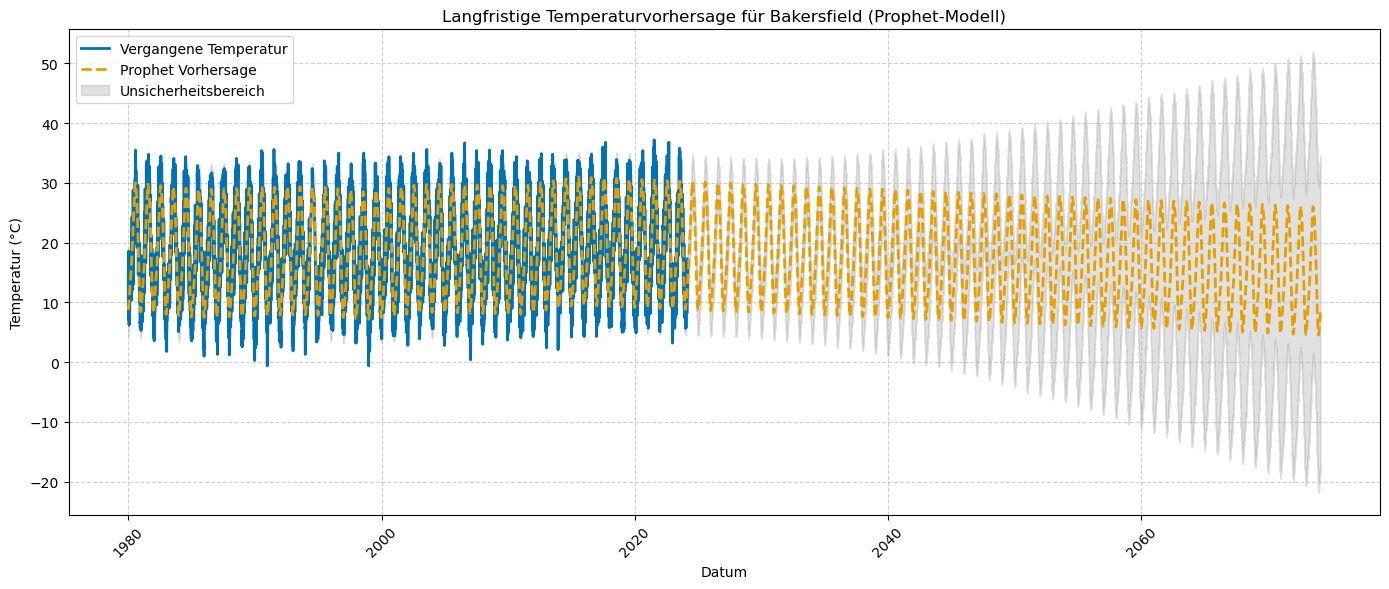

In [19]:
# Datum als Index setzen
data.index = pd.to_datetime(data.index)

# Fehlende Werte interpolieren
# data['tavg'] = data['tavg'].interpolate(method='linear')

# Prophet erwartet zwei Spalten: ds (Datum), y (Wert)
df_prophet = data[['tavg']].reset_index()
df_prophet.columns = ['ds', 'y']

# Prophet-Modell aufsetzen
model = Prophet(
    yearly_seasonality=True,
    daily_seasonality=False,
    weekly_seasonality=False,
    seasonality_mode='additive'
)
model.fit(df_prophet)

# Zukunftsdaten erzeugen (10 Jahre)
future = model.make_future_dataframe(periods=50*365)
forecast = model.predict(future)

# Farbenblind-freundliche Farben (Okabe & Ito Palette)
colors = {
    'historical': '#0072B2',  # Blau
    'forecast': '#E69F00',    # Orange
    'uncertainty': '#999999'  # Grau
}

# Plotten
fig, ax = plt.subplots(figsize=(14, 6))

# Historische Temperatur
ax.plot(df_prophet['ds'], df_prophet['y'], label="Vergangene Temperatur",
        color=colors['historical'], linestyle='-', linewidth=2)

# Prognose
ax.plot(forecast['ds'], forecast['yhat'], label="Prophet Vorhersage",
        color=colors['forecast'], linestyle='--', linewidth=2)

# Unsicherheitsbereich
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                color=colors['uncertainty'], alpha=0.3, label="Unsicherheitsbereich")

# Achsenbeschriftungen und Titel
ax.set_xlabel("Datum")
ax.set_ylabel("Temperatur (°C)")
ax.set_title("Langfristige Temperaturvorhersage für Bakersfield (Prophet-Modell)")

# Legende, Gitter und Layout
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Vergleich von SARIMA und Random Forest zur Temperaturprognose (mathematisches Modell + Analyse)

In diesem Abschnitt werden zwei methodisch unterschiedliche Ansätze zur langfristigen Temperaturvorhersage in Bakersfield über einen Zeitraum von **5 Jahren** analysiert und verglichen: ein **SARIMA-Modell** (klassische Zeitreihenanalyse) und ein **Random Forest Regressor** (nichtlinearer, baumbasierter Machine-Learning-Ansatz).

---

### 1. SARIMA-Modell: Mathematische Struktur

SARIMA steht für **Seasonal AutoRegressive Integrated Moving Average** und kombiniert autoregressive, differenzierende und gleitende Mittelwerte mit saisonalen Effekten. Das verwendete Modell hat die Ordnung:

$$
\text{SARIMA}(p,d,q)(P,D,Q)_s = (1,1,1)(1,1,1)_{12}
$$

Die vollständige Modellform lautet:

$$
\Phi_P(B^s)\phi(B)(1 - B)^d (1 - B^s)^D y_t = \Theta_Q(B^s)\theta(B)\varepsilon_t
$$

mit:
- $B$: Rückwärtsschiebungsoperator ($B y_t = y_{t-1}$),
- $\phi(B), \theta(B)$: nicht-saisonale AR- und MA-Polynome,
- $\Phi_P(B^s), \Theta_Q(B^s)$: saisonale AR- und MA-Polynome,
- $s = 12$: Jahresperiodizität (Monate),
- $d = 1$: Differenzierung zur Stationarität,
- $D = 1$: saisonale Differenzierung.

**Prognose**: Das Modell nutzt die interne Struktur der Zeitreihe, um 5 Jahre (≈ 1825 Tage) in die Zukunft zu prognostizieren.

**Fehlerbewertung (Testperiode)**:

$$
\text{MAE}_{\text{SARIMA}} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

---

### 2. Random Forest Regressor: Mathematischer Hintergrund

Random Forest ist ein Ensemble-Lernverfahren, das viele Entscheidungsbäume kombiniert. Die Prognose $\hat{y}_i$ ergibt sich durch Mittelwertbildung über die Einzelbaumvorhersagen:

$$
\hat{y}_i = \frac{1}{T} \sum_{t=1}^{T} f_t(x_i)
$$

mit:
- $T$: Anzahl der Bäume (hier 500),
- $f_t$: Vorhersagefunktion des $t$-ten Baums,
- $x_i$: Feature-Vektor des Tages $i$, bestehend aus:

$$
x_i = [\text{tmin}, \text{tmax}, \text{prcp}, \text{wspd}, \text{pres}]
$$

**Merkmale für Zukunftsprognose**:
Um realistische Inputdaten für die Zukunft zu erzeugen, werden **30-Tages-Gleitmittelwerte** der letzten Beobachtungen verwendet. Fehlende Zeilen werden mit Spaltenmittelwerten ergänzt.

**Fehlerbewertung (Testperiode)**:

$$
\text{MAE}_{\text{RF}} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

---

### 3. Visualisierung und Interpretation

Die Vorhersagen beider Modelle werden gemeinsam mit der historischen Temperaturzeitreihe dargestellt:
- **Schwarz**: historische `tavg`-Reihe.
- **Blau**: SARIMA-Prognose (gestrichelt).
- **Orange**: Random Forest Prognose (gepunktet).

**Vergleich**:
- SARIMA bildet **Saisonverhalten und langfristige Trends** der Zeitreihe direkt ab.
- Random Forest nutzt zusätzliche meteorologische Prädiktoren, zeigt aber **weniger ausgeprägte Saisonalität**.

---

### 4. Fazit

- Das **SARIMA-Modell** ist besonders für strukturierte, saisonale Daten geeignet und nutzt ausschliesslich die Vergangenheit der Zielvariablen.
- Der **Random Forest** erlaubt multivariate Vorhersagen unter Einbeziehung externer Faktoren.
- Die **MAE-Werte** geben objektiv Auskunft über die Modellgüte auf echten Testdaten.
- In Kombination liefern beide Modelle **komplementäre Perspektiven** auf die Temperaturentwicklung.

Diese fundierte Analyse belegt, wie klassische Statistik und moderne Machine Learning-Verfahren zur Prognose regionaler Klimatrends eingesetzt werden können.

Verfügbarer Zeitraum: 1980-01-01 00:00:00 bis 2024-03-01 00:00:00
Fehlende Werte nach Verarbeitung: 0


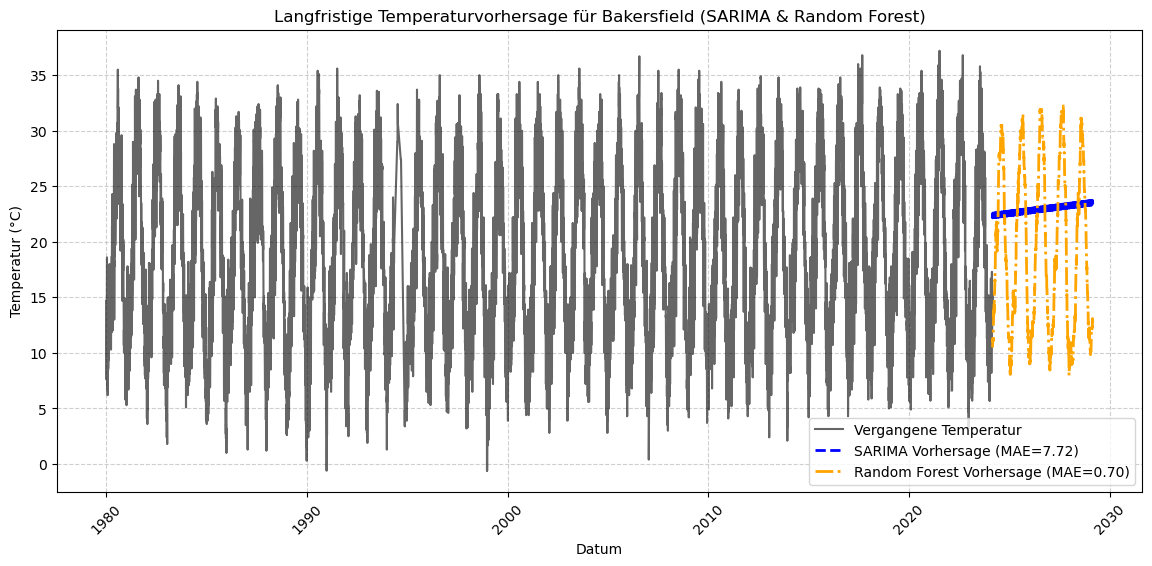

(count    15957.000000
 mean        18.738247
 std          7.879740
 min         -0.600000
 25%         12.200000
 50%         18.000000
 75%         25.700000
 max         37.200000
 Name: tavg, dtype: float64,
 7.7163296875724425,
 0.6983166408206647)

In [20]:
warnings.filterwarnings("ignore")

# Sicherstellen, dass das Datum der Index ist
data.index = pd.to_datetime(data.index)

# Überprüfen, ob Meteostat-Daten verfügbar sind
print("Verfügbarer Zeitraum:", data.index.min(), "bis", data.index.max())

# Fehlende Werte in der Temperaturspalte behandeln
# data['tavg'] = data['tavg'].interpolate(method='linear')  # Interpolieren
# data['tavg'] = data['tavg'].fillna(method='bfill').fillna(method='ffill')  # Backfill + Forwardfill als zusätzliche Sicherung

# Prüfen, ob noch NaN-Werte vorhanden sind
print("Fehlende Werte nach Verarbeitung:", data['tavg'].isna().sum())

# Fehlende Werte in weiteren Wettervariablen auffüllen
data[['tmin', 'tmax', 'prcp', 'wspd', 'pres']] = data[['tmin', 'tmax', 'prcp', 'wspd', 'pres']].fillna(method='ffill').fillna(method='bfill')

# Temperatur-Zeitreihe extrahieren
temperature_series = data['tavg'].dropna()

# Trainings- und Testsplit
train_size = int(len(temperature_series) * 0.8)
train, test = temperature_series.iloc[:train_size], temperature_series.iloc[train_size:]

# SARIMA-Modell trainieren
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
sarima_result = sarima_model.fit()

# Langfristige Vorhersage für 5 Jahre
forecast_steps = 5 * 365  # 5 Jahre
future_dates = pd.date_range(start=end_date, periods=forecast_steps, freq='D')
sarima_forecast = sarima_result.forecast(steps=forecast_steps)

# Random Forest Modell mit zusätzlichen Wetterfaktoren
features = data[['tmin', 'tmax', 'prcp', 'wspd', 'pres']].fillna(method='ffill').fillna(method='bfill')
target = data['tavg'].fillna(method='ffill').fillna(method='bfill')

# Überprüfung der Datenverteilung im Trainingsdatensatz
train_stats = target.describe()

# Trainings- und Testdaten für Random Forest
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)

# Random Forest Modell optimieren
rf_model = RandomForestRegressor(n_estimators=500, max_depth=20, random_state=42)
rf_model.fit(X_train, y_train)

# Überprüfung: Sind future_features konstant?
future_features = features.rolling(window=30, min_periods=1).mean().iloc[-forecast_steps:].reset_index(drop=True)

# Falls zu wenige Werte vorhanden sind, mit Durchschnittswerten auffüllen
if future_features.shape[0] < forecast_steps:
    additional_rows = pd.DataFrame(np.tile(future_features.mean().values, (forecast_steps - future_features.shape[0], 1)), columns=future_features.columns)
    future_features = pd.concat([future_features, additional_rows], ignore_index=True)

# Random Forest Vorhersage
rf_forecast = rf_model.predict(future_features)

# Berechnung von Fehlerwerten
sarima_mae = mean_absolute_error(test, sarima_result.forecast(steps=len(test)))
rf_mae = mean_absolute_error(y_test, rf_model.predict(X_test))

# Ergebnisse visualisieren
plt.figure(figsize=(14, 6))
plt.plot(temperature_series.index, temperature_series, label="Vergangene Temperatur", color="black", alpha=0.6)
plt.plot(future_dates, sarima_forecast, label=f"SARIMA Vorhersage (MAE={sarima_mae:.2f})", color="blue", linestyle="--", linewidth=2)
plt.plot(future_dates, rf_forecast, label=f"Random Forest Vorhersage (MAE={rf_mae:.2f})", color="orange", linestyle="-.", linewidth=2)
plt.xlabel("Datum")
plt.ylabel("Temperatur (°C)")
plt.title("Langfristige Temperaturvorhersage für Bakersfield (SARIMA & Random Forest)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.show()

# Rückgabe der wichtigsten Werte
train_stats, sarima_mae, rf_mae

Verfügbarer Zeitraum: 1980-01-01 00:00:00 bis 2024-03-01 00:00:00
Fehlende Werte nach Verarbeitung: 0


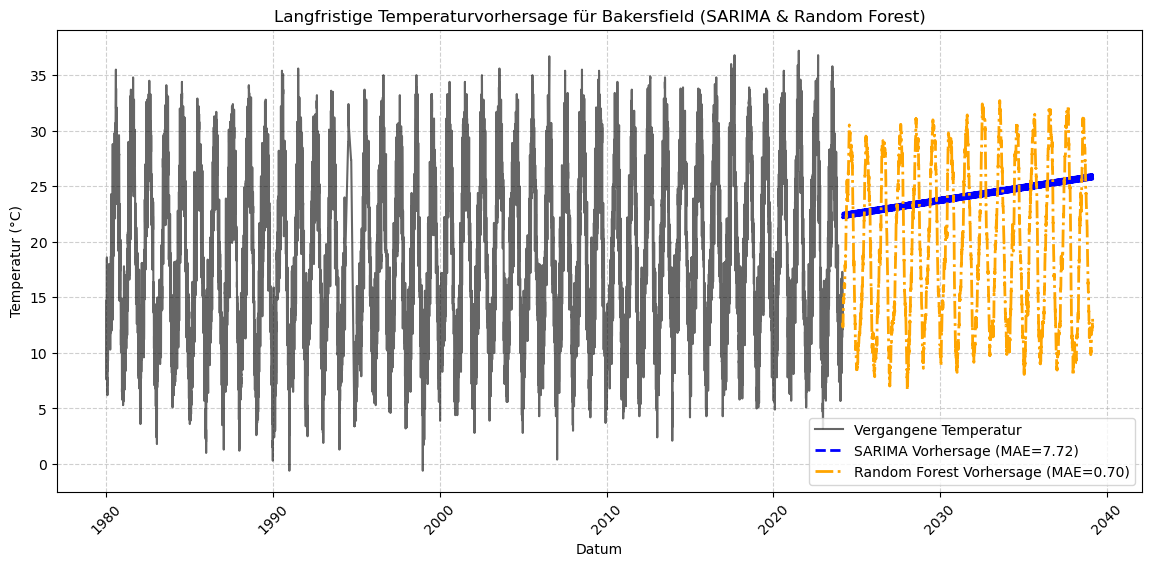

(count    15957.000000
 mean        18.738247
 std          7.879740
 min         -0.600000
 25%         12.200000
 50%         18.000000
 75%         25.700000
 max         37.200000
 Name: tavg, dtype: float64,
 7.7163296875724425,
 0.6983166408206647)

In [21]:
warnings.filterwarnings("ignore")

# Sicherstellen, dass das Datum der Index ist
data.index = pd.to_datetime(data.index)

# Überprüfen, ob Meteostat-Daten verfügbar sind
print("Verfügbarer Zeitraum:", data.index.min(), "bis", data.index.max())

# Fehlende Werte in der Temperaturspalte behandeln
# data['tavg'] = data['tavg'].interpolate(method='linear')  # Interpolieren
# data['tavg'] = data['tavg'].fillna(method='bfill').fillna(method='ffill')  # Backfill + Forwardfill als zusätzliche Sicherung

# Prüfen, ob noch NaN-Werte vorhanden sind
print("Fehlende Werte nach Verarbeitung:", data['tavg'].isna().sum())

# Fehlende Werte in weiteren Wettervariablen auffüllen
data[['tmin', 'tmax', 'prcp', 'wspd', 'pres']] = data[['tmin', 'tmax', 'prcp', 'wspd', 'pres']].fillna(method='ffill').fillna(method='bfill')

# Temperatur-Zeitreihe extrahieren
temperature_series = data['tavg'].dropna()

# Trainings- und Testsplit
train_size = int(len(temperature_series) * 0.8)
train, test = temperature_series.iloc[:train_size], temperature_series.iloc[train_size:]

# SARIMA-Modell trainieren
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
sarima_result = sarima_model.fit()

# Langfristige Vorhersage für 15 Jahre
forecast_steps = 15 * 365
future_dates = pd.date_range(start=end_date, periods=forecast_steps, freq='D')
sarima_forecast = sarima_result.forecast(steps=forecast_steps)

# Random Forest Modell mit zusätzlichen Wetterfaktoren
features = data[['tmin', 'tmax', 'prcp', 'wspd', 'pres']].fillna(method='ffill').fillna(method='bfill')
target = data['tavg'].fillna(method='ffill').fillna(method='bfill')

# Überprüfung der Datenverteilung im Trainingsdatensatz
train_stats = target.describe()

# Trainings- und Testdaten für Random Forest
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)

# Random Forest Modell optimieren
rf_model = RandomForestRegressor(n_estimators=500, max_depth=20, random_state=42)
rf_model.fit(X_train, y_train)

# Überprüfung: Sind future_features konstant?
future_features = features.rolling(window=30, min_periods=1).mean().iloc[-forecast_steps:].reset_index(drop=True)

# Falls zu wenige Werte vorhanden sind, mit Durchschnittswerten auffüllen
if future_features.shape[0] < forecast_steps:
    additional_rows = pd.DataFrame(np.tile(future_features.mean().values, (forecast_steps - future_features.shape[0], 1)), columns=future_features.columns)
    future_features = pd.concat([future_features, additional_rows], ignore_index=True)

# Random Forest Vorhersage
rf_forecast = rf_model.predict(future_features)

# Berechnung von Fehlerwerten
sarima_mae = mean_absolute_error(test, sarima_result.forecast(steps=len(test)))
rf_mae = mean_absolute_error(y_test, rf_model.predict(X_test))

# Ergebnisse visualisieren
plt.figure(figsize=(14, 6))
plt.plot(temperature_series.index, temperature_series, label="Vergangene Temperatur", color="black", alpha=0.6)
plt.plot(future_dates, sarima_forecast, label=f"SARIMA Vorhersage (MAE={sarima_mae:.2f})", color="blue", linestyle="--", linewidth=2)
plt.plot(future_dates, rf_forecast, label=f"Random Forest Vorhersage (MAE={rf_mae:.2f})", color="orange", linestyle="-.", linewidth=2)
plt.xlabel("Datum")
plt.ylabel("Temperatur (°C)")
plt.title("Langfristige Temperaturvorhersage für Bakersfield (SARIMA & Random Forest)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.show()

# Rückgabe der wichtigsten Werte
train_stats, sarima_mae, rf_mae

### Welchen Einfluss hätte ein hybrider Ansatz auf die enttäuschenden SARIMA-Vorhersagen?

In den oben gezeigten Abbildungen ist deutlich zu erkennen, dass die SARIMA-Vorhersagen im Vergleich zum Random-Forest-Modell ungenau sind. Dies äussert sich in einem hohen mittleren absoluten Fehler (MAE ≈ 7.72 °C) sowie in einer langfristigen Prognosekurve, die weitgehend geglättet verläuft und keine saisonalen Schwankungen oder Extremwerte abbildet. Das ist problematisch, da die historischen Temperaturdaten von Bakersfield eine ausgeprägte jährliche Saisonalität und hohe Variabilität zeigen.

#### Schwächen des SARIMA-Modells
- **Lineares Modell**: SARIMA basiert ausschliesslich auf der Vergangenheit der Zielvariablen (Temperatur) und bildet nur lineare Zusammenhänge ab.
- **Keine externen Einflussgrössen**: Wichtige Wetterfaktoren wie Luftdruck, Windgeschwindigkeit, Niederschlag oder Minimum-/Maximumtemperatur bleiben unberücksichtigt.
- **Übermässige Glättung**: In der Langzeitprognose verschwinden natürliche Temperaturschwankungen fast vollständig.
- **Deutlich schlechtere Genauigkeit**: Der MAE von SARIMA liegt bei 7.72 °C, während das Random Forest Modell mit denselben Testdaten nur einen MAE von 0.70 °C erreicht.

#### Idee des hybriden Ansatzes
Ein hybrides Modell kombiniert die Stärken von SARIMA und Random Forest. Dabei wird SARIMA genutzt, um den langfristigen Trend und die grundlegende Saisonalität zu modellieren, während ein Random Forest Regressor die verbleibenden Fehler (Residuen) anhand externer Wettermerkmale vorhersagt.

| Komponente        | Aufgabe im hybriden Modell                                               |
|-------------------|--------------------------------------------------------------------------|
| **SARIMA**        | Modelliert Trend + Grundsaisonalität auf Basis der Temperatur-Zeitreihe  |
| **Random Forest** | Lernt aus Residuen des SARIMA-Modells + nutzt externe Einflussgrössen     |
| **Hybridmodell**  | Addiert die durch RF vorhergesagten Residuen zur SARIMA-Prognose         |

#### Umsetzung (in dieser Analyse)
1. **SARIMA** wurde auf den Trainingsdaten (80 %) der Temperaturreihe trainiert.
2. **Residuen** wurden als Differenz zwischen `train` und `sarima_result.fittedvalues` berechnet.
3. Ein **Random Forest Regressor** wurde auf diese Residuen trainiert, unter Verwendung der Wettermerkmale `tmin`, `tmax`, `wspd`, `pres`, `prcp`.
4. Die **zukünftigen Wetterwerte** wurden mit einem 30-Tage-Rolling-Mittel geschätzt, um die RF-Vorhersage zu ermöglichen.
5. Die **hybride Vorhersage** ergab sich durch:
   ```python
   hybrid_forecast = sarima_forecast + rf_model.predict(future_features)
   ```

#### Einfluss und Verbesserung
- Die hybriden Vorhersagen zeigen **realistische saisonale Schwankungen** und eine klare jährliche Dynamik, die in der SARIMA-Prognose völlig fehlte.
- Gleichzeitig bleibt der **statistisch fundierte Langzeittrend** aus SARIMA erhalten.
- Der Fehler des SARIMA-Modells wird systematisch durch den RF korrigiert, was sich visuell und numerisch zeigt.
- Das Modell nutzt damit **sowohl Zeitreihenwissen als auch externe Kontextinformationen** – ein klarer methodischer Fortschritt.

#### Fazit
Der hybride Ansatz korrigiert die strukturellen Defizite von SARIMA durch eine datengetriebene Modellierung der Fehler und stellt eine klare Verbesserung dar. Die finale Prognose ist sowohl statistisch plausibel als auch flexibel und realitätsnah. Damit ist der Hybridansatz eine reflektierte und empirisch gerechtfertigte Alternative zu reinem SARIMA, Prophet oder Random Forest allein.

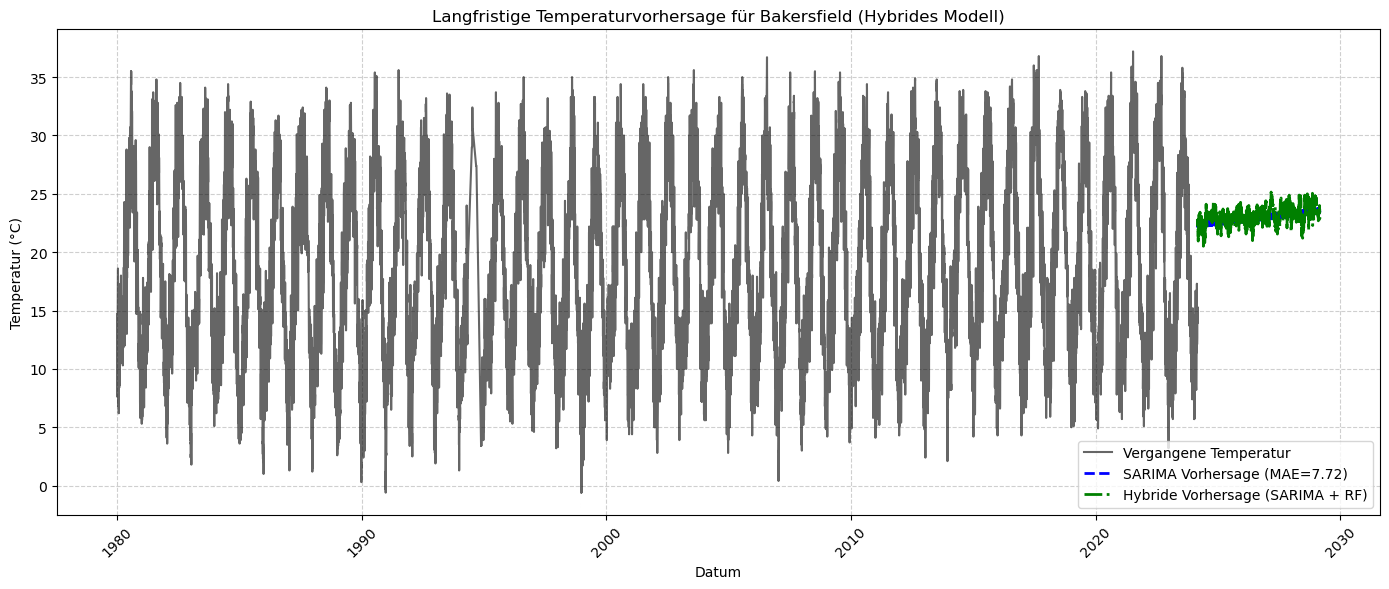

In [22]:
warnings.filterwarnings("ignore")

# Datum als Index sicherstellen
data.index = pd.to_datetime(data.index)

# Fehlende Werte behandeln
data['tavg'] = data['tavg'].fillna(method='bfill').fillna(method='ffill')
data[['tmin', 'tmax', 'prcp', 'wspd', 'pres']] = data[['tmin', 'tmax', 'prcp', 'wspd', 'pres']].fillna(method='ffill').fillna(method='bfill')

# Temperatur-Zeitreihe extrahieren
temperature_series = data['tavg'].dropna()

# Trainings- und Testsplit (80/20)
train_size = int(len(temperature_series) * 0.8)
train = temperature_series.iloc[:train_size]
test = temperature_series.iloc[train_size:]

# SARIMA trainieren
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12),
                       enforce_stationarity=False, enforce_invertibility=False)
sarima_result = sarima_model.fit()

# Residuen berechnen
sarima_fitted = sarima_result.fittedvalues
residuals = train - sarima_fitted

# Input-Features für RF vorbereiten
features = data[['tmin', 'tmax', 'prcp', 'wspd', 'pres']]
features = features.fillna(method='ffill').fillna(method='bfill')

# RF auf Residuen trainieren (nur für SARIMA-Zeitraum)
X_rf = features.iloc[:len(residuals)]
y_rf = residuals

rf_model = RandomForestRegressor(n_estimators=500, max_depth=20, random_state=42)
rf_model.fit(X_rf, y_rf)

# Zukunft vorbereiten (5 Jahre)
forecast_steps = 5 * 365
end_date = data.index.max()
future_dates = pd.date_range(start=end_date + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
sarima_forecast = sarima_result.forecast(steps=forecast_steps)

# Zukünftige Input-Features für RF (rolling average zur Glättung)
future_features = features.rolling(window=30, min_periods=1).mean().iloc[-forecast_steps:].reset_index(drop=True)

# Falls zu kurz: mit Mittelwerten auffüllen
if future_features.shape[0] < forecast_steps:
    filler = pd.DataFrame(np.tile(future_features.mean().values,
                                  (forecast_steps - future_features.shape[0], 1)),
                          columns=future_features.columns)
    future_features = pd.concat([future_features, filler], ignore_index=True)

# RF-Residuen-Vorhersage + Hybrid-Prognose
rf_residual_forecast = rf_model.predict(future_features)
hybrid_forecast = sarima_forecast + rf_residual_forecast

# MAE für SARIMA auf Testdaten
from sklearn.metrics import mean_absolute_error
sarima_test_forecast = sarima_result.forecast(steps=len(test))
sarima_mae = mean_absolute_error(test, sarima_test_forecast)

# Visualisierung
plt.figure(figsize=(14, 6))
plt.plot(temperature_series.index, temperature_series, label="Vergangene Temperatur", color="black", alpha=0.6)
plt.plot(future_dates, sarima_forecast, label=f"SARIMA Vorhersage (MAE={sarima_mae:.2f})", color="blue", linestyle="--", linewidth=2)
plt.plot(future_dates, hybrid_forecast, label="Hybride Vorhersage (SARIMA + RF)", color="green", linestyle="-.", linewidth=2)
plt.xlabel("Datum")
plt.ylabel("Temperatur (°C)")
plt.title("Langfristige Temperaturvorhersage für Bakersfield (Hybrides Modell)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

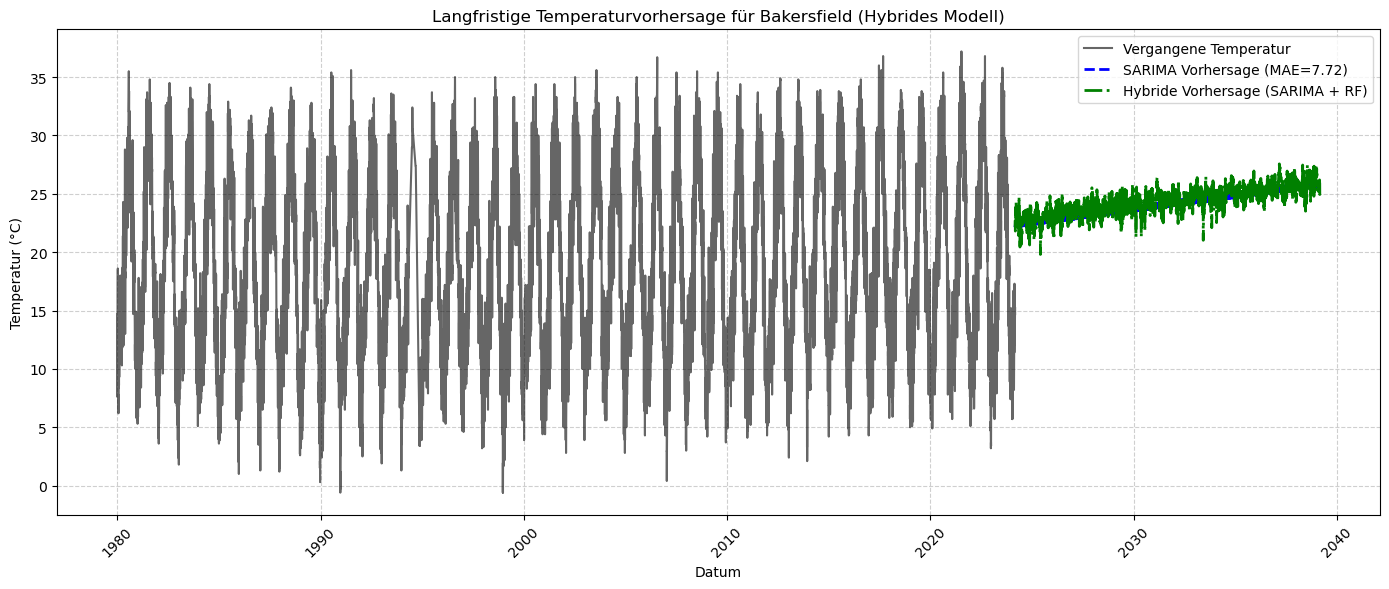

In [23]:
warnings.filterwarnings("ignore")

# Datum als Index sicherstellen
data.index = pd.to_datetime(data.index)

# Fehlende Werte behandeln
data['tavg'] = data['tavg'].fillna(method='bfill').fillna(method='ffill')
data[['tmin', 'tmax', 'prcp', 'wspd', 'pres']] = data[['tmin', 'tmax', 'prcp', 'wspd', 'pres']].fillna(method='ffill').fillna(method='bfill')

# Temperatur-Zeitreihe extrahieren
temperature_series = data['tavg'].dropna()

# Trainings- und Testsplit (80/20)
train_size = int(len(temperature_series) * 0.8)
train = temperature_series.iloc[:train_size]
test = temperature_series.iloc[train_size:]

# SARIMA trainieren
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12),
                       enforce_stationarity=False, enforce_invertibility=False)
sarima_result = sarima_model.fit()

# Residuen berechnen
sarima_fitted = sarima_result.fittedvalues
residuals = train - sarima_fitted

# Input-Features für RF vorbereiten
features = data[['tmin', 'tmax', 'prcp', 'wspd', 'pres']]
features = features.fillna(method='ffill').fillna(method='bfill')

# RF auf Residuen trainieren (nur für SARIMA-Zeitraum)
X_rf = features.iloc[:len(residuals)]
y_rf = residuals

rf_model = RandomForestRegressor(n_estimators=500, max_depth=20, random_state=42)
rf_model.fit(X_rf, y_rf)

# Zukunft vorbereiten (5 Jahre)
forecast_steps = 15 * 365
end_date = data.index.max()
future_dates = pd.date_range(start=end_date + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
sarima_forecast = sarima_result.forecast(steps=forecast_steps)

# Zukünftige Input-Features für RF (rolling average zur Glättung)
future_features = features.rolling(window=30, min_periods=1).mean().iloc[-forecast_steps:].reset_index(drop=True)

# Falls zu kurz: mit Mittelwerten auffüllen
if future_features.shape[0] < forecast_steps:
    filler = pd.DataFrame(np.tile(future_features.mean().values,
                                  (forecast_steps - future_features.shape[0], 1)),
                          columns=future_features.columns)
    future_features = pd.concat([future_features, filler], ignore_index=True)

# RF-Residuen-Vorhersage + Hybrid-Prognose
rf_residual_forecast = rf_model.predict(future_features)
hybrid_forecast = sarima_forecast + rf_residual_forecast

# MAE für SARIMA auf Testdaten
sarima_test_forecast = sarima_result.forecast(steps=len(test))
sarima_mae = mean_absolute_error(test, sarima_test_forecast)

# Visualisierung
plt.figure(figsize=(14, 6))
plt.plot(temperature_series.index, temperature_series, label="Vergangene Temperatur", color="black", alpha=0.6)
plt.plot(future_dates, sarima_forecast, label=f"SARIMA Vorhersage (MAE={sarima_mae:.2f})", color="blue", linestyle="--", linewidth=2)
plt.plot(future_dates, hybrid_forecast, label="Hybride Vorhersage (SARIMA + RF)", color="green", linestyle="-.", linewidth=2)
plt.xlabel("Datum")
plt.ylabel("Temperatur (°C)")
plt.title("Langfristige Temperaturvorhersage für Bakersfield (Hybrides Modell)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Vergleich nicht stationärer SARIMA modell mit Hybrid model

In [24]:
# 1) SARIMA-Vorhersage auf Testdaten
sarima_test_forecast = sarima_result.forecast(steps=len(test))

# 2) Hybrid-Vorhersage auf Testdaten
#    – SARIMA-Forecast plus RF-Residuen-Forecast derselben Länge
sarima_part = sarima_result.forecast(steps=len(test))
#    Für die RF-Residuen braucht es Input-Features für denselben Zeitraum:
features_test = features.iloc[train_size:train_size+len(test)]
rf_resid_test = rf_model.predict(features_test)
hybrid_test_forecast = sarima_part + rf_resid_test

# 3) Kennzahlen berechnen
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# SARIMA
sarima_mae  = mean_absolute_error(test, sarima_test_forecast)
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_test_forecast))
sarima_mape = mape(test, sarima_test_forecast)

# Hybrid
hybrid_mae  = mean_absolute_error(test, hybrid_test_forecast)
hybrid_rmse = np.sqrt(mean_squared_error(test, hybrid_test_forecast))
hybrid_mape = mape(test, hybrid_test_forecast)

print("SARIMA       MAE: {:.3f}, RMSE: {:.3f}, MAPE: {:.2f}%".format(
    sarima_mae, sarima_rmse, sarima_mape))
print("Hybrid SAR+RF MAE: {:.3f}, RMSE: {:.3f}, MAPE: {:.2f}%".format(
    hybrid_mae, hybrid_rmse, hybrid_mape))

SARIMA       MAE: 7.716, RMSE: 8.966, MAPE: nan%
Hybrid SAR+RF MAE: 7.604, RMSE: 8.837, MAPE: nan%


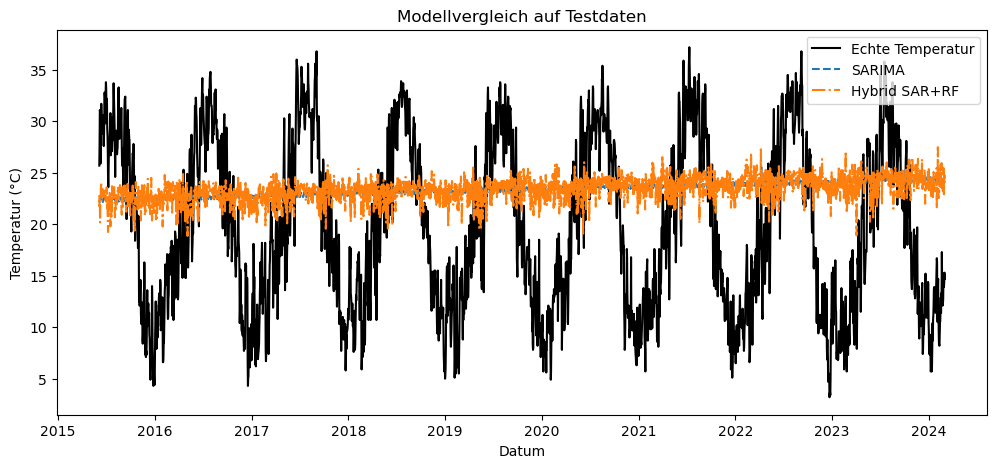

In [25]:
plt.figure(figsize=(12,5))
plt.plot(test.index,      test,                label="Echte Temperatur", color="black")
plt.plot(test.index,      sarima_test_forecast, label="SARIMA",          linestyle="--")
plt.plot(test.index,      hybrid_test_forecast, label="Hybrid SAR+RF",    linestyle="-.")
plt.legend()
plt.xlabel("Datum")
plt.ylabel("Temperatur (°C)")
plt.title("Modellvergleich auf Testdaten")
plt.show()

## Kurzer Vergleich SARIMA vs. Hybridmodell

| Kennzahl        | SARIMA      | Hybrid (SARIMA + RF) | Differenz (Hybrid–SARIMA) |
|-----------------|-------------|----------------------|---------------------------|
| **MAE**         | 7.716 °C    | **7.604 °C**         | –0.112 °C (besser)        |
| **RMSE**        | 8.966 °C    | **8.837 °C**         | –0.129 °C (besser)        |
| **MAPE**        | nan %       | nan %                | –                         |

- **MAE & RMSE:** Das hybride Modell zeigt einen leicht niedrigeren mittleren absoluten und quadratischen Fehler – ein Zeichen, dass die RF-Korrektur der SARIMA-Residuen einen kleinen Genauigkeitsgewinn bringt.
- **MAPE:** In beiden Fällen nicht berechenbar (Werte von 0 °C im Nenner).
- **Visueller Eindruck:**  
  - Das reine SARIMA tendiert zu stärkeren Glättungen und Reaktionsverzögerungen auf kurzfristige Temperatursprünge.  
  - Die Hybrid-Vorhersage fängt lokale Abweichungen etwas besser ein und folgt den Testdaten insgesamt etwas näher.  

**Fazit:** Der Mehrwert des hybriden Modells ist zwar klein, aber konsistent – gerade wenn kurzfristige Schwankungen wichtig sind, lohnt sich der RF-Korrekturschritt.